### lipidspot & plin2 results across batches

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statannotations.Annotator import Annotator
from aicsimageio import AICSImage

import sys
path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
sys.path.append(path_to_quant)

from confocalQuant.stats import fit_mixed_model
from confocalQuant.plotting import get_batch_values, plot_boxplot_across_batches

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from aicsimageio import AICSImage
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statannotations.Annotator import Annotator
import pandas as pd

from confocalQuant.stats import compute_nested_anova

def get_batch_values(subset_by_group,subset_to,test_grouping,split,path,batch_ID,value, keep_line, keep_treatment, filter_):
    df = pd.read_csv(path)
    
    if filter_:
        df = df[np.array([x in keep_line for x in df['line']]) & np.array([y in keep_treatment for y in df['treatment']])]
        
    df['well'] = [x.split(split)[0] for x in df['file']]
    avg_lipidspot = df.groupby([subset_by_group, test_grouping, 'well'])[value].mean().reset_index(name='av')
    avg_lipidspot = avg_lipidspot[avg_lipidspot[subset_by_group]==subset_to]
    avg_lipidspot['scaled'] = (avg_lipidspot['av']-np.mean(avg_lipidspot['av']))/np.std(avg_lipidspot['av'])
    avg_lipidspot['batch'] = batch_ID
    return avg_lipidspot

def plot_boxplot_across_batches(subset_by_group,subset_to,test_grouping,split,path,batch_ID,value,colors,colors2,categories, keep_line, keep_treatment, filter_, size):
    out = [get_batch_values(subset_by_group,subset_to,test_grouping,split[x],path[x],batch_ID[x],value, keep_line, keep_treatment, filter_) for x in range(len(path))]
    temp = pd.concat(out)

    temp_plotting = temp.copy()
    temp_plotting[test_grouping] = pd.Categorical(temp_plotting[test_grouping], categories=categories, ordered=True)

    temp_plotting.index = range(temp_plotting.shape[0])

    plt.figure(figsize=size)
    ax = sns.boxplot(data = temp_plotting, x = test_grouping, showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=temp_plotting, x=test_grouping, y='scaled',  dodge=True, jitter=True, alpha=.5,  palette = colors2)

    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('Mean ' + value + ' Intensity (z-scaled)')
    
    return temp


In [9]:
### is it correct how I'm computing the p-values across batches?, is the scaling correct?

#### Lipidspot

In [2]:
df = pd.read_csv('../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv')
df = df[(df['lipidspot']>0) & (df['plin2']>0)]

In [3]:
df['ls'] = np.log2(df['lipidspot'])
df['pl'] = np.log2(df['plin2'])

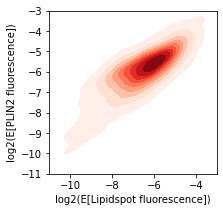

In [4]:
plt.figure(figsize=(3,3))
sns.kdeplot(x=df['ls'], y=df['pl'], cmap="Reds", fill=True)
plt.xlim(-11,-3)
plt.ylim(-11,-3)
plt.ylabel('log2(E[PLIN2 fluorescence])')
plt.xlabel('log2(E[Lipidspot fluorescence])')
plt.savefig('../out_plots/plin_lipidspot_corr.pdf', bbox_inches='tight')


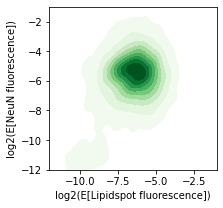

In [5]:
df = pd.read_csv('../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv')
df = df[(df['lipidspot']>0) & (df['neun']>0)]

df['ls'] = np.log2(df['lipidspot'])
df['pl'] = np.log2(df['neun'])

plt.figure(figsize=(3,3))
sns.kdeplot(x=df['ls'], y=df['pl'], cmap="Greens", fill=True)
plt.xlim(-12,-1)
plt.ylim(-12,-1)
plt.ylabel('log2(E[NeuN fluorescence])')
plt.xlabel('log2(E[Lipidspot fluorescence])')
plt.savefig('../out_plots/lipidspot_neun_corr.pdf', bbox_inches='tight')


In [3]:
import numpy as np
from scipy.stats import chi2, norm

def combine_pvalues_fisher(p_values):
    statistic = -2 * np.sum(np.log(p_values))
    combined_p = 1 - chi2.cdf(statistic, 2 * len(p_values))
    return combined_p

# Example p-values from multiple experiments
p_values = [0.04, 0.02, 0.05, 0.01]
combined_p = combine_pvalues_fisher(p_values)
print("Combined P-value (Fisher's Method):", combined_p)

Combined P-value (Fisher's Method): 0.0002628434779397004


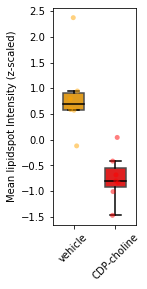

In [14]:
# compute the meta-p-values / batch p-values correctly
paths = [#'../new_outs/iNbatch01172024_CTP1b_Lipidspot_out//quant_continuous.csv']#,
         #'../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         #'../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv']#,
        #'../new_outs/iNbatch02282024_PLIN2_lipidspot_out/quant_continuous.csv']#,
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant_continuous.csv']#]

split = ['_','-', '_', '_', '_']

colors = dict(zip(['vehicle', 'rosiglitazone', 'CDP-choline'], [ 'orange' , 'violet','red']))
colors2 = dict(zip(['vehicle', 'rosiglitazone', 'CDP-choline'], [ 'orange' , 'purple','red']))

batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02282024', 'iNbatch02142024']


temp_LS = plot_boxplot_across_batches('line','Y622','treatment',split,paths,batch_id,'lipidspot',colors,colors2,['vehicle',  'CDP-choline'],  keep_line=set(['Y622']), keep_treatment=set(['vehicle', 'CDP-choline']), filter_=True, size=(1.5,4))

plt.savefig('../out_plots/lipidspot_y622.pdf', bbox_inches='tight')


In [9]:
x = pd.read_csv('../new_outs/iNbatch01312024_PLIN2_Lipidspot_out//quant_continuous.csv')

x['well'] = [i.split('_')[0] for i in x['file']]

print(fit_mixed_model(x[(x['treatment']=='CDP-choline') | (x['treatment']=='vehicle') & (x['line']=='Y622')], "lipidspot ~ treatment", 'well'))
print(fit_mixed_model(x[(x['treatment']=='CDP-choline') | (x['treatment']=='vehicle') & (x['line']=='Y622')], "plin2 ~ treatment", 'well'))

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   lipidspot 
No. Observations:   3689      Method:               REML      
No. Groups:         30        Scale:                0.0001    
Min. group size:    42        Log-Likelihood:       11520.6386
Max. group size:    227       Converged:            Yes       
Mean group size:    123.0                                     
--------------------------------------------------------------
                     Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.012    0.001 13.663 0.000  0.011  0.014
treatment[T.vehicle] 0.005    0.002  2.653 0.008  0.001  0.008
Group Var            0.000    0.000                           

            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   plin2    
No. Observations:    3689      Method:               REML     
No. Groups:      

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
# y622 lipidspot
[0.197, 0.008

Unnamed: 0      dapi      neun  lipidspot     size  file_ID  mask_ID  \
0               0  0.005269  0.000121   0.002380    332.0        0        1   
1               1  0.008535  0.000776   0.001042    839.0        0        2   
2               2  0.000320  0.022401   0.000242   2375.0        0        3   
3               3  0.000916  0.031413   0.000754   1677.0        0        4   
4               4  0.041998  0.246575   0.005193  20824.0        0        5   
...           ...       ...       ...        ...      ...      ...      ...   
15542         120  0.101562  0.040003   0.002207    615.0      109      121   
15543         121  0.061008  0.018094   0.003179   2223.0      109      122   
15544         122  0.025428  0.008273   0.003672   3742.0      109      123   
15545         123  0.035661  0.004724   0.004130    805.0      109      124   
15546         124  0.010797  0.003025   0.002267    712.0      109      125   

            file  line      treatment  
0      B02_1.czi  Y622        vehicle  
1      B02_1.czi  Y622        vehicle  
2      B02_1.czi  Y622        vehicle  
3      B02_1.czi  Y622        vehicle  
4      B02_1.czi  Y622        vehicle  
...          ...   ...            ...  
15542  G11_2.czi    G2  rosiglitazone  
15543  G11_2.czi    G2  rosiglitazone  
15544  G11_2.czi    G2  rosiglitazone  
15545  G11_2.czi    G2  rosiglitazone  
15546  G11_2.czi    G2  rosiglitazone  

[15547 rows x 10 columns]

In [5]:
fit_mixed_model(temp_LS[temp_LS['treatment']!='rosiglitazone'], "scaled ~ treatment", 'batch')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM    Dependent Variable:    scaled  
No. Observations:    64         Method:                REML    
No. Groups:          5          Scale:                 0.8924  
Min. group size:     11         Log-Likelihood:        -87.9089
Max. group size:     16         Converged:             Yes     
Mean group size:     12.8                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.346    0.162 -2.134 0.033 -0.663 -0.028
treatment[T.vehicle]  0.738    0.237  3.118 0.002  0.274  1.201
Group Var             0.000                                    
===============================================================

"""

In [86]:
np.unique(temp_LS['treatment'],return_counts=True)

(array(['CDP-choline', 'vehicle'], dtype=object), array([34, 30]))

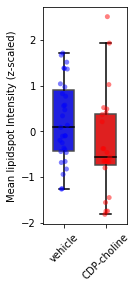

In [6]:
# compute the meta-p-values / batch p-values correctly
paths = ['../new_outs/iNbatch01172024_CTP1b_Lipidspot_out//quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02282024_PLIN2_lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','-', '_', '_', '_']

colors = dict(zip(['vehicle', 'rosiglitazone', 'CDP-choline'], [ 'blue' , 'violet','red']))
colors2 = dict(zip(['vehicle', 'rosiglitazone', 'CDP-choline'], [ 'blue' , 'purple','red']))

batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02282024', 'iNbatch02142024']


temp_LS = plot_boxplot_across_batches('line','G2','treatment',split,paths,batch_id,'lipidspot',colors,colors2,['vehicle', 'CDP-choline'], keep_line=set(['G2']), keep_treatment=set(['vehicle', 'CDP-choline']), filter_=True, size=(1.5,4))

plt.savefig('../out_plots/lipidspot_g2.pdf', bbox_inches='tight')


In [124]:
np.unique(temp_LS['well'])

array(['B02', 'B03', 'B05', 'B07', 'B08', 'B09', 'B10', 'B11', 'C03',
       'C04', 'C05', 'C07', 'C08', 'C09', 'C10', 'C11', 'D02', 'D03',
       'D04', 'D05', 'D07', 'D08', 'D09', 'D10', 'D11', 'E03', 'E05',
       'E07', 'E08', 'E09', 'E10'], dtype=object)

In [7]:
fit_mixed_model(temp_LS[temp_LS['treatment']!='rosiglitazone'], "scaled ~ treatment", 'batch')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM    Dependent Variable:    scaled  
No. Observations:    54         Method:                REML    
No. Groups:          5          Scale:                 0.9722  
Min. group size:     7          Log-Likelihood:        -76.4434
Max. group size:     18         Converged:             No      
Mean group size:     10.8                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.294    0.208 -1.409 0.159 -0.702  0.115
treatment[T.vehicle]  0.511    0.271  1.884 0.060 -0.021  1.043
Group Var             0.005                                    
===============================================================

"""

In [116]:
x = temp_LS[temp_LS['treatment']=='CDP-choline']['scaled']
y = temp_LS[temp_LS['treatment']=='vehicle']['scaled']

from scipy import stats
stats.ttest_ind(x,y)

Ttest_indResult(statistic=-1.8826099420099007, pvalue=0.06535345601183809)

#### PLIN2

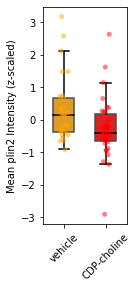

In [8]:
# compute the meta-p-values / batch p-values correctly
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out///quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02282024_PLIN2_lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','-', '_', '_', '_']


colors = dict(zip(['vehicle', 'rosiglitazone', 'CDP-choline'], [ 'orange' , 'violet','red']))
colors2 = dict(zip(['vehicle', 'rosiglitazone', 'CDP-choline'], [ 'orange' , 'purple','red']))

batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02282024', 'iNbatch02142024']

temp_PL = plot_boxplot_across_batches('line','Y622','treatment',split,paths,batch_id,'plin2',colors,colors2,['vehicle','CDP-choline'],  keep_line=set(['Y622']), keep_treatment=set(['vehicle', 'CDP-choline']), filter_=True, size=(1.5,4))

plt.savefig('../out_plots/plin2_y622.pdf', bbox_inches='tight')


In [108]:
np.unique(temp_PL['treatment'],return_counts=True)

(array(['CDP-choline', 'vehicle'], dtype=object), array([34, 28]))

In [126]:
np.unique(temp_PL['well'])

array(['B02', 'B03', 'B04', 'B05', 'B08', 'B09', 'B11', 'C02', 'C03',
       'C04', 'C05', 'C07', 'C08', 'C09', 'D02', 'D03', 'D04', 'D05',
       'D07', 'D08', 'D09', 'D10', 'D11', 'E02', 'E03', 'E04', 'E05',
       'E08', 'E09'], dtype=object)

In [113]:
x = temp_PL[temp_PL['treatment']=='CDP-choline']['scaled']
y = temp_PL[temp_PL['treatment']=='vehicle']['scaled']

from scipy import stats
stats.ttest_ind(x,y)

Ttest_indResult(statistic=-2.4199136138029025, pvalue=0.018570274414838685)

In [95]:
fit_mixed_model(temp_PL[temp_PL['treatment']!='rosiglitazone'], "scaled ~ treatment", 'batch')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM    Dependent Variable:    scaled  
No. Observations:    62         Method:                REML    
No. Groups:          5          Scale:                 0.9414  
Min. group size:     11         Log-Likelihood:        -86.7842
Max. group size:     14         Converged:             No      
Mean group size:     12.4                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.271    0.167 -1.620 0.105 -0.598  0.057
treatment[T.vehicle]  0.599    0.248  2.420 0.016  0.114  1.085
Group Var             0.001                                    
===============================================================

"""

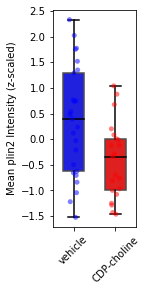

In [9]:
# compute the meta-p-values / batch p-values correctly
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out///quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02282024_PLIN2_lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','-', '_', '_', '_']

colors = dict(zip(['vehicle', 'rosiglitazone', 'CDP-choline'], [ 'blue' , 'violet','red']))
colors2 = dict(zip(['vehicle', 'rosiglitazone', 'CDP-choline'], [ 'blue' , 'purple','red']))

batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02282024', 'iNbatch02142024']

temp_PL = plot_boxplot_across_batches('line','G2','treatment',split,paths,batch_id,'plin2',colors,colors2,['vehicle',  'CDP-choline'],  keep_line=set(['G2']), keep_treatment=set(['vehicle', 'CDP-choline']), filter_=True, size=(1.5,4))

plt.savefig('../out_plots/plin2_g2.pdf', bbox_inches='tight')


In [129]:
np.unique(temp_PL['well'])

array(['B02', 'B03', 'B05', 'B08', 'B09', 'B10', 'B11', 'C03', 'C04',
       'C05', 'C08', 'C09', 'C10', 'C11', 'D02', 'D03', 'D04', 'D05',
       'D07', 'D08', 'D09', 'D10', 'D11', 'E03', 'E05', 'E08', 'E09',
       'E11'], dtype=object)

In [101]:
np.unique(temp_PL['treatment'],return_counts=True)

(array(['CDP-choline', 'vehicle'], dtype=object), array([21, 25]))

In [102]:
fit_mixed_model(temp_PL[temp_PL['treatment']!='rosiglitazone'], "scaled ~ treatment", 'batch')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM    Dependent Variable:    scaled  
No. Observations:    46         Method:                REML    
No. Groups:          5          Scale:                 0.8943  
Min. group size:     7          Log-Likelihood:        -63.1064
Max. group size:     12         Converged:             Yes     
Mean group size:     9.2                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.415    0.206 -2.018 0.044 -0.818 -0.012
treatment[T.vehicle]  0.763    0.279  2.736 0.006  0.217  1.310
Group Var             0.000                                    
===============================================================

"""

#### E3 vs Y622 vs G2

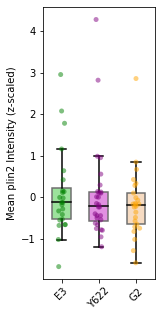

In [103]:
# compute the meta-p-values / batch p-values correctly
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out///quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02282024_PLIN2_lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','-', '_', '_', '_']

colors = dict(zip(['E3', 'Y622', 'G2'], [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(['E3', 'Y622', 'G2'], [ 'green' , 'purple','orange']))

batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02282024', 'iNbatch02142024']

temp = plot_boxplot_across_batches('treatment','vehicle','line',split,paths,batch_id,'plin2',colors,colors2,['E3', 'Y622', 'G2'],  keep_line=set(['E3', 'Y622', 'G2']), keep_treatment=set(['vehicle']), filter_=True)

In [104]:
fit_mixed_model(temp[temp['line']!='Y622'], "scaled ~ line", 'batch')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
======================================================
Model:            MixedLM Dependent Variable: scaled  
No. Observations: 49      Method:             REML    
No. Groups:       5       Scale:              0.8817  
Min. group size:  4       Log-Likelihood:     -66.9313
Max. group size:  15      Converged:          Yes     
Mean group size:  9.8                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.094    0.205  0.459 0.646 -0.307  0.495
line[T.G2]  -0.247    0.281 -0.880 0.379 -0.797  0.303
Group Var    0.000    0.075                           
======================================================

"""

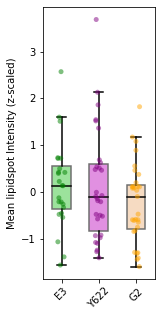

In [105]:
# compute the meta-p-values / batch p-values correctly
paths = ['../new_outs/iNbatch01172024_CTP1b_Lipidspot_out///quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02282024_PLIN2_lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','-', '_', '_', '_']

colors = dict(zip(['E3', 'Y622', 'G2'], [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(['E3', 'Y622', 'G2'], [ 'green' , 'purple','orange']))

batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02282024', 'iNbatch02142024']

temp = plot_boxplot_across_batches('treatment','vehicle','line',split,paths,batch_id,'lipidspot',colors,colors2,['E3', 'Y622', 'G2'], keep_line=set(['E3', 'Y622', 'G2']), keep_treatment=set(['vehicle']), filter_=True)

In [106]:
fit_mixed_model(temp[temp['line']!='G2'], "scaled ~ line", 'batch')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:             MixedLM Dependent Variable: scaled  
No. Observations:  54      Method:             REML    
No. Groups:        5       Scale:              1.1410  
Min. group size:   6       Log-Likelihood:     -81.3526
Max. group size:   17      Converged:          No      
Mean group size:   10.8                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.188    0.298  0.632 0.527 -0.395  0.772
line[T.Y622] -0.073    0.354 -0.205 0.838 -0.767  0.622
Group Var     0.063    0.284                           
=======================================================

"""

# below is scrap

rosiglitazone vs. vehicle: t-test independent samples, P_val:6.859e-03 t=-2.807e+00
CDP-choline vs. vehicle: t-test independent samples, P_val:2.724e-02 t=-2.263e+00


Text(0.5, 21.5, '')

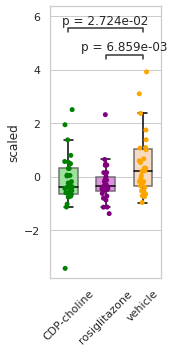

In [329]:
# compute the meta-p-values / batch p-values correctly
# make below into functionsb
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out///quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02282024_PLIN2_lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','-', '_', '_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02282024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'plin2', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

#temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

In [ ]:
## is it correct how I'm doing the mixed effects p-values??

In [319]:
np.unique(temp['line'])

array(['Y622'], dtype=object)

In [326]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
temp = temp[temp['treatment']!='CDP-choline']
# Assuming df is your DataFrame
model = smf.mixedlm("scaled ~ treatment", data=temp, groups=temp["batch"])
result = model.fit()

print(result.pvalues)

print(result.conf_int())

print(result.converged)

Intercept               0.155989
treatment[T.vehicle]    0.004856
Group Var                    NaN
dtype: float64
                             0         1
Intercept            -0.583926  0.093547
treatment[T.vehicle]  0.214540  1.196486
Group Var                  NaN       NaN
True


/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [328]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
temp = temp[temp['treatment']!='rosiglitazone']
# Assuming df is your DataFrame
model = smf.mixedlm("scaled ~ treatment", data=temp, groups=temp["batch"])
result = model.fit()

print(result.pvalues)

print(result.conf_int())

print(result.converged)

Intercept    0.123839
Group Var    0.451821
dtype: float64
                  0         1
Intercept -0.132711  1.102645
Group Var -0.394926  0.887044
True


Intercept               0.321092
treatment[T.vehicle]    0.012145
Group Var               1.000000
dtype: float64

0         1
Intercept            -0.608075  0.199332
treatment[T.vehicle]  0.152757  1.245576
Group Var            -0.492466  0.492466

True

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming df is your DataFrame
model = smf.mixedlm("y ~ x1 + x2", data=df, groups=df["composite_group"])
result = model.fit()

In [258]:
compute_nested_anova(temp[temp['treatment']!='CDP-choline'], 'scaled', 'treatment', 'batch')

LinAlgError: Singular matrix

In [251]:
compute_nested_anova(temp[temp['treatment']=='CDP-choline'], 'scaled', 'treatment', 'batch')

line    treatment well        av    scaled            batch
0    Y622  CDP-choline  D02  0.011685 -0.425687  iNbatch01172024
1    Y622  CDP-choline  D03  0.015316  0.960315  iNbatch01172024
2    Y622  CDP-choline  D04  0.012699 -0.038698  iNbatch01172024
3    Y622  CDP-choline  D05  0.013713  0.348416  iNbatch01172024
4    Y622  CDP-choline  E02  0.012891  0.034562  iNbatch01172024
..    ...          ...  ...       ...       ...              ...
104  Y622      vehicle  B09  0.011074  0.772891  iNbatch02142024
105  Y622      vehicle  B11  0.011495  0.997478  iNbatch02142024
106  Y622      vehicle  C07  0.011808  1.164690  iNbatch02142024
107  Y622      vehicle  C08  0.011045  0.757421  iNbatch02142024
108  Y622      vehicle  C09  0.009628  0.001701  iNbatch02142024

[109 rows x 6 columns]

vehicle vs. rosiglitazone: t-test independent samples, P_val:2.882e-01 t=1.122e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:3.200e-01 t=1.060e+00


Text(0.5, 21.5, '')

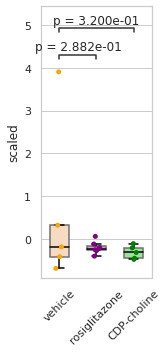

In [332]:
# compute the meta-p-values / batch p-values correctly
# make below into functionsb
paths = [
         '../new_outs/iNbatch01312024_CPT1b_NRF2_out//quant.csv'] 
        #'../new_outs/iNbatch02282024_Ctp1b_NRF2_out//quant.csv']

split = ['_','_', '_', '_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02282024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'cpt1b', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

'Coef: -0.866\n95% CI: [-1.36,-0.371] \np: 5.969668e-04'

In [175]:
temp.head()

line    treatment well        av    scaled            batch
0  Y622  CDP-choline  D02  0.011685 -0.425687  iNbatch01172024
1  Y622  CDP-choline  D03  0.015316  0.960315  iNbatch01172024
2  Y622  CDP-choline  D04  0.012699 -0.038698  iNbatch01172024
3  Y622  CDP-choline  D05  0.013713  0.348416  iNbatch01172024
4  Y622  CDP-choline  E02  0.012891  0.034562  iNbatch01172024

In [192]:
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.formula.api import mixedlm
def compute_nested_anova(resE, score, group, nested_col):
    """
    Compute nested ANOVA statistics and return the results as a formatted text.

    Parameters:
    - resE (pd.DataFrame): DataFrame containing data for analysis.
    - score (str): Dependent variable.
    - group (str): Grouping variable for the ANOVA.
    - nested_col (str): Nested column for grouping.

    Returns:
    - str: Formatted text containing ANOVA coefficients, 95% CI, and p-value.
    """
    # Fit a two-level ANOVA model
    model = mixedlm(score + '~' + group, resE, groups=resE[nested_col])
    #vc = {'well': '0 + C(well)'}
    #model = Mixedlm.from_formula('score ~ group', vc_formula=vc,re_formula='1', groups='batch', data=resE)
    
    result = model.fit()

    p = result.pvalues[1]
    
    p_scientific = "{:e}".format(p)

    coef = result.params[1]
    lower = result.conf_int().iloc[1][0]
    upper = result.conf_int().iloc[1][1]
    text0 = 'Coef: ' + str(np.round(coef,3)) + '\n95% CI: [' + str(np.round(lower,3)) + ',' + str(np.round(upper,3)) + '] \n' + 'p: ' + str(p_scientific)
    
    return text0   

In [191]:
help(statsmodels.regression.mixed_linear_model.MixedLM)

NameError: name 'statsmodels' is not defined

vehicle vs. rosiglitazone: t-test independent samples, P_val:8.859e-04 t=3.488e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:7.163e-03 t=2.769e+00


Text(0.5, 21.5, '')

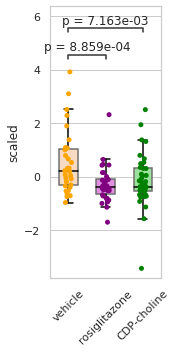

In [170]:
# compute the meta-p-values / batch p-values correctly
# make below into functionsb
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out////quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02282024_PLIN2_lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','_', '_', '_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02282024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'plin2', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

In [169]:
temp

line    treatment       well        av    scaled            batch
0    Y622  CDP-choline  D02_1.czi  0.014778 -3.593176  iNbatch01172024
1    Y622  CDP-choline  D03_1.czi  0.024159 -1.030808  iNbatch01172024
2    Y622  CDP-choline  D03_2.czi  0.029479  0.422058  iNbatch01172024
3    Y622  CDP-choline  D04_1.czi  0.029898  0.536574  iNbatch01172024
4    Y622  CDP-choline  D04_2.czi  0.031306  0.921100  iNbatch01172024
..    ...          ...        ...       ...       ...              ...
123  Y622      vehicle        B09  0.016348  0.666277  iNbatch02142024
124  Y622      vehicle        B11  0.017660  1.089167  iNbatch02142024
125  Y622      vehicle        C07  0.017395  1.003852  iNbatch02142024
126  Y622      vehicle        C08  0.017595  1.068360  iNbatch02142024
127  Y622      vehicle        C09  0.015922  0.528930  iNbatch02142024

[128 rows x 6 columns]

In [ ]:
# is the way I'm doing these stats correct? 
# try / compute meta p-values

In [150]:
import numpy as np
from scipy.stats import cauchy

def cauchy_combination(p_values):
    """
    Combine p-values using the Cauchy combination method.
    
    Parameters:
    - p_values: An array of p-values to combine.
    
    Returns:
    - combined_p_value: The combined p-value from the Cauchy combination test.
    """
    # Transform p-values to Cauchy-distributed variables
    y_values = np.tan(np.pi * (p_values - 0.5))
    
    # Sum the transformed values
    Y = np.sum(y_values)
    
    # Calculate the combined p-value
    combined_p_value = cauchy.cdf(Y)
    
    # Adjust for the two-tailed test
    if combined_p_value > 0.5:
        combined_p_value = 1.0 - combined_p_value
    
    return combined_p_value * 2  # Return two-tailed p-value

# Example usage
p_values = np.array([6.021e-01, 2.339e-03, 1.127e-03,1.886e-01,7.883e-01])
combined_p_value = cauchy_combination(p_values)
print("Combined p-value:", combined_p_value)

Combined p-value: 0.0015215455492101349


In [ ]:
cauchy_combination

vehicle vs. rosiglitazone: t-test independent samples, P_val:4.998e-01 t=-6.957e-01
vehicle vs. CDP-choline: t-test independent samples, P_val:5.429e-01 t=-6.261e-01
vehicle vs. rosiglitazone: t-test independent samples, P_val:5.971e-04 t=4.407e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:2.828e-03 t=3.402e+00
vehicle vs. rosiglitazone: t-test independent samples, P_val:8.742e-04 t=4.675e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:6.589e-04 t=4.692e+00
vehicle vs. rosiglitazone: t-test independent samples, P_val:3.431e-01 t=9.952e-01
vehicle vs. CDP-choline: t-test independent samples, P_val:2.540e-01 t=1.210e+00
vehicle vs. rosiglitazone: t-test independent samples, P_val:5.949e-01 t=-5.492e-01
vehicle vs. CDP-choline: t-test independent samples, P_val:7.491e-01 t=-3.288e-01


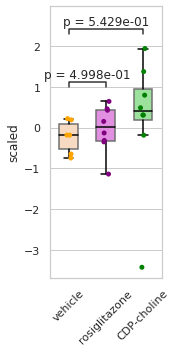

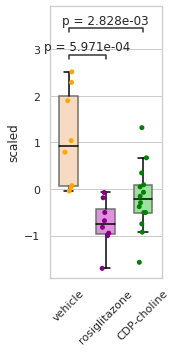

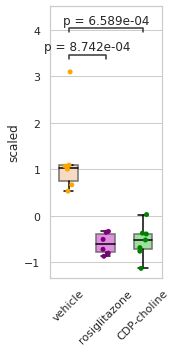

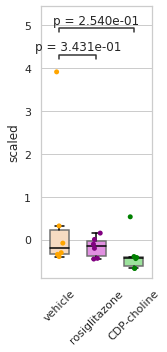

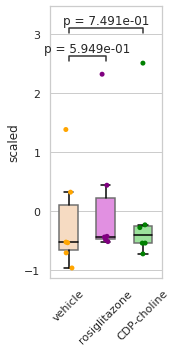

In [171]:
# compute the meta-p-values / batch p-values correctly
# make below into functionsb
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out///quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02282024_PLIN2_lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','_', '_', '_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02282024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'plin2', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

for i in np.unique(temp['batch']):
    temp2 = temp[temp['batch']==i]
    plt.figure(figsize=(2,5))
    ax = sns.boxplot(data = temp2, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=temp2, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

    pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
    annotator = Annotator(ax, pairs, data=temp2, x='treatment', y='scaled')
    annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
    annotator.apply_and_annotate()
    plt.xticks(rotation=45)
    plt.xlabel('')

In [151]:
help(annotator.configure)

Help on method configure in module statannotations.Annotator:

configure(**parameters) method of statannotations.Annotator.Annotator instance
    * `alpha`: Acceptable type 1 error for statistical tests, default 0.05
    * `color`
    * `comparisons_correction`: Method for multiple comparisons correction.
        One of `statsmodels` `multipletests` methods (w/ default FWER), or
        a `ComparisonsCorrection` instance.
    * `correction_format`: How to format the star notation on the plot when
        the multiple comparisons correction method removes the significance
        * `default`: a ' (ns)' suffix is added, such as in printed output,
        corresponds to "{star} ({suffix})"
        * `replace`: the original star value is replaced with 'ns'
        corresponds to "{suffix}"
        * a custom formatting string using "{star}" for the original
        pvalue and '{suffix}' for 'ns'
    * `hide_non_significant`: hide annotations for non-significant pair
        comparisons
   

In [59]:
x = pd.read_csv('../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv')
#x = pd.read_csv('../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv')

In [60]:
x['ratio'] = x['lipidspot']/x['plin2']

In [61]:
import sys
path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
sys.path.append(path_to_quant)
from confocalQuant.plotting import plot_boxplot_by_treatment

In [62]:
x['well'] = [x.split('_')[0] for x in x['file']]

In [63]:
x

Unnamed: 0      dapi      neun  lipidspot     plin2    size  file_ID  \
0              0  0.000478  0.020054   0.000384  0.001113  4107.0        0   
1              1  0.000132  0.015643   0.000395  0.000468  1590.0        0   
2              2  0.017444  0.000447   0.003170  0.001342   670.0        0   
3              3  0.022044  0.088733   0.013070  0.009272  8908.0        0   
4              4  0.001401  0.101821   0.002713  0.004833  4106.0        0   
...          ...       ...       ...        ...       ...     ...      ...   
9320         139  0.031340  0.005367   0.000596  0.003808   506.0       74   
9321         140  0.014543  0.001917   0.001302  0.002558   691.0       74   
9322         141  0.012373  0.000333   0.000432  0.000570   942.0       74   
9323         142  0.015459  0.000246   0.000717  0.000464   534.0       74   
9324         143  0.006585  0.000126   0.000974  0.000429   531.0       74   

      mask_ID       file  line      treatment     ratio       well  
0           1  B03-1.czi  Y622        vehicle  0.344968  B03-1.czi  
1           2  B03-1.czi  Y622        vehicle  0.844988  B03-1.czi  
2           3  B03-1.czi  Y622        vehicle  2.362650  B03-1.czi  
3           4  B03-1.czi  Y622        vehicle  1.409536  B03-1.czi  
4           5  B03-1.czi  Y622        vehicle  0.561317  B03-1.czi  
...       ...        ...   ...            ...       ...        ...  
9320      140  G11-4.czi    G2  rosiglitazone  0.156465  G11-4.czi  
9321      141  G11-4.czi    G2  rosiglitazone  0.508984  G11-4.czi  
9322      142  G11-4.czi    G2  rosiglitazone  0.757221  G11-4.czi  
9323      143  G11-4.czi    G2  rosiglitazone  1.544438  G11-4.czi  
9324      144  G11-4.czi    G2  rosiglitazone  2.266806  G11-4.czi  

[9325 rows x 13 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


vehicle vs. CDP-choline: t-test independent samples, P_val:2.339e-03 t=3.484e+00
vehicle vs. rosiglitazone: t-test independent samples, P_val:6.764e-04 t=4.342e+00


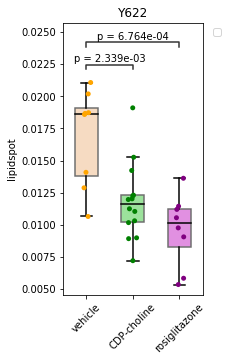

In [65]:
plt.figure(figsize=(2.5,5))


plot_boxplot_by_treatment('lipidspot', 'Y622', x, colors, colors2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


vehicle vs. CDP-choline: t-test independent samples, P_val:2.540e-01 t=1.210e+00
vehicle vs. rosiglitazone: t-test independent samples, P_val:3.431e-01 t=9.952e-01


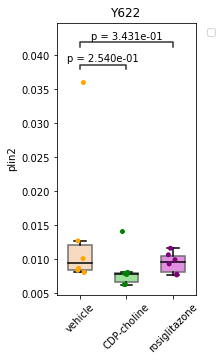

In [58]:
plt.figure(figsize=(2.5,5))


plot_boxplot_by_treatment('plin2', 'Y622', x, colors, colors2)

In [27]:
# compute the meta-p-values / batch p-values correctly
# make below into functionsb
paths = [
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['-','_', '_']
batch_id = [ 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'lipidspot', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp_ls = pd.concat(out)

paths = [
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['-','_', '_']
batch_id = [ 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'plin2', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp_plin = pd.concat(out)

In [31]:
temp_plin

line      treatment well        av    scaled            batch
17  Y622    CDP-choline  D03  0.020776  0.567309  iNbatch01312024
18  Y622    CDP-choline  D04  0.014387 -1.026211  iNbatch01312024
19  Y622    CDP-choline  D05  0.016080 -0.603926  iNbatch01312024
20  Y622    CDP-choline  E02  0.018687  0.046237  iNbatch01312024
21  Y622    CDP-choline  E03  0.018733  0.057727  iNbatch01312024
22  Y622    CDP-choline  E04  0.019731  0.306571  iNbatch01312024
23  Y622    CDP-choline  E05  0.015528 -0.741508  iNbatch01312024
24  Y622  rosiglitazone  F03  0.017764 -0.183883  iNbatch01312024
25  Y622  rosiglitazone  F05  0.015981 -0.628716  iNbatch01312024
26  Y622  rosiglitazone  G04  0.013948 -1.135562  iNbatch01312024
27  Y622  rosiglitazone  G05  0.012968 -1.380102  iNbatch01312024
28  Y622        vehicle  B03  0.018584  0.020452  iNbatch01312024
29  Y622        vehicle  B05  0.027985  2.365166  iNbatch01312024
30  Y622        vehicle  C04  0.020876  0.592101  iNbatch01312024
31  Y622        vehicle  C05  0.025496  1.744346  iNbatch01312024
23  Y622    CDP-choline  D03  0.007947 -0.417374  iNbatch02212024
24  Y622    CDP-choline  D04  0.008095 -0.394443  iNbatch02212024
25  Y622    CDP-choline  D05  0.014100  0.532535  iNbatch02212024
26  Y622    CDP-choline  E03  0.006314 -0.669407  iNbatch02212024
27  Y622    CDP-choline  E04  0.006300 -0.671526  iNbatch02212024
28  Y622    CDP-choline  E05  0.007783 -0.442685  iNbatch02212024
29  Y622  rosiglitazone  F03  0.007816 -0.437586  iNbatch02212024
30  Y622  rosiglitazone  F04  0.009334 -0.203173  iNbatch02212024
31  Y622  rosiglitazone  F05  0.007714 -0.453371  iNbatch02212024
32  Y622  rosiglitazone  G03  0.010678  0.004280  iNbatch02212024
33  Y622  rosiglitazone  G04  0.009959 -0.106648  iNbatch02212024
34  Y622  rosiglitazone  G05  0.011637  0.152285  iNbatch02212024
35  Y622        vehicle  B03  0.036020  3.916606  iNbatch02212024
36  Y622        vehicle  B04  0.012721  0.319763  iNbatch02212024
37  Y622        vehicle  B05  0.008673 -0.305246  iNbatch02212024
38  Y622        vehicle  C03  0.008414 -0.345284  iNbatch02212024
39  Y622        vehicle  C04  0.008079 -0.396956  iNbatch02212024
40  Y622        vehicle  C05  0.010121 -0.081767  iNbatch02212024

In [30]:
temp_plin

line      treatment well        av    scaled            batch
17  Y622    CDP-choline  D03  0.020776  0.567309  iNbatch01312024
18  Y622    CDP-choline  D04  0.014387 -1.026211  iNbatch01312024
19  Y622    CDP-choline  D05  0.016080 -0.603926  iNbatch01312024
20  Y622    CDP-choline  E02  0.018687  0.046237  iNbatch01312024
21  Y622    CDP-choline  E03  0.018733  0.057727  iNbatch01312024
22  Y622    CDP-choline  E04  0.019731  0.306571  iNbatch01312024
23  Y622    CDP-choline  E05  0.015528 -0.741508  iNbatch01312024
24  Y622  rosiglitazone  F03  0.017764 -0.183883  iNbatch01312024
25  Y622  rosiglitazone  F05  0.015981 -0.628716  iNbatch01312024
26  Y622  rosiglitazone  G04  0.013948 -1.135562  iNbatch01312024
27  Y622  rosiglitazone  G05  0.012968 -1.380102  iNbatch01312024
28  Y622        vehicle  B03  0.018584  0.020452  iNbatch01312024
29  Y622        vehicle  B05  0.027985  2.365166  iNbatch01312024
30  Y622        vehicle  C04  0.020876  0.592101  iNbatch01312024
31  Y622        vehicle  C05  0.025496  1.744346  iNbatch01312024
23  Y622    CDP-choline  D03  0.007947 -0.417374  iNbatch02212024
24  Y622    CDP-choline  D04  0.008095 -0.394443  iNbatch02212024
25  Y622    CDP-choline  D05  0.014100  0.532535  iNbatch02212024
26  Y622    CDP-choline  E03  0.006314 -0.669407  iNbatch02212024
27  Y622    CDP-choline  E04  0.006300 -0.671526  iNbatch02212024
28  Y622    CDP-choline  E05  0.007783 -0.442685  iNbatch02212024
29  Y622  rosiglitazone  F03  0.007816 -0.437586  iNbatch02212024
30  Y622  rosiglitazone  F04  0.009334 -0.203173  iNbatch02212024
31  Y622  rosiglitazone  F05  0.007714 -0.453371  iNbatch02212024
32  Y622  rosiglitazone  G03  0.010678  0.004280  iNbatch02212024
33  Y622  rosiglitazone  G04  0.009959 -0.106648  iNbatch02212024
34  Y622  rosiglitazone  G05  0.011637  0.152285  iNbatch02212024
35  Y622        vehicle  B03  0.036020  3.916606  iNbatch02212024
36  Y622        vehicle  B04  0.012721  0.319763  iNbatch02212024
37  Y622        vehicle  B05  0.008673 -0.305246  iNbatch02212024
38  Y622        vehicle  C03  0.008414 -0.345284  iNbatch02212024
39  Y622        vehicle  C04  0.008079 -0.396956  iNbatch02212024
40  Y622        vehicle  C05  0.010121 -0.081767  iNbatch02212024

/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/gridsan/djuna/.local/l

vehicle vs. rosiglitazone: t-test independent samples, P_val:2.559e-02 t=2.335e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:3.106e-02 t=2.242e+00


Text(0.5, 24.0, '')

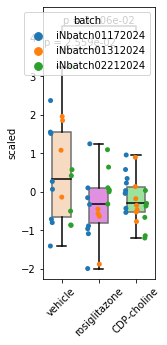

In [19]:
# compute the meta-p-values / batch p-values correctly
# make below into functionsb
paths = ['../new_outs/iNbatch01172024_CTP1b_Lipidspot_out/quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','-','_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'lipidspot', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled', hue='batch', dodge=True, jitter=True, alpha=1)#,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

vehicle vs. rosiglitazone: t-test independent samples, P_val:1.854e-01 t=-1.353e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:9.222e-01 t=9.851e-02


Text(0.5, 24.0, '')

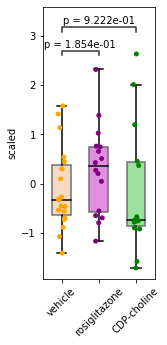

In [9]:
# compute the meta-p-values / batch p-values correctly
# make below into functionsb
paths = ['../new_outs/iNbatch01172024_CTP1b_Lipidspot_out/quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','-','_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'lipidspot', 'G2', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

vehicle vs. rosiglitazone: t-test independent samples, P_val:6.941e-01 t=-3.977e-01
vehicle vs. CDP-choline: t-test independent samples, P_val:5.443e-01 t=6.154e-01


Text(0.5, 24.0, '')

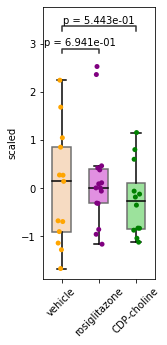

In [12]:
# compute the meta-p-values / batch p-values correctly
# make below into functionsb
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out/quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','-','_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'plin2', 'G2', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

vehicle vs. rosiglitazone: t-test independent samples, P_val:4.990e-02 t=2.038e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:2.021e-01 t=1.300e+00


Text(0.5, 24.0, '')

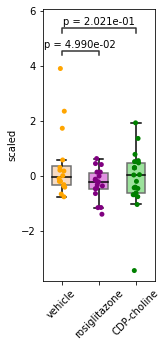

In [17]:
# compute the meta-p-values / batch p-values correctly
# make below into functionsb
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out/quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv']

split = ['_','-','_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'plin2', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

In [14]:
temp

line      treatment well        av    scaled            batch
0   Y622    CDP-choline  D02  0.014778 -3.427347  iNbatch01172024
1   Y622    CDP-choline  D03  0.026981 -0.185651  iNbatch01172024
2   Y622    CDP-choline  D04  0.030677  0.796138  iNbatch01172024
3   Y622    CDP-choline  D05  0.029513  0.486904  iNbatch01172024
4   Y622    CDP-choline  E02  0.028845  0.309604  iNbatch01172024
5   Y622    CDP-choline  E03  0.032855  1.374841  iNbatch01172024
6   Y622    CDP-choline  E04  0.034988  1.941402  iNbatch01172024
7   Y622    CDP-choline  E05  0.028837  0.307333  iNbatch01172024
8   Y622  rosiglitazone  F02  0.028252  0.152099  iNbatch01172024
9   Y622  rosiglitazone  F03  0.029285  0.426438  iNbatch01172024
10  Y622  rosiglitazone  F04  0.026362 -0.350174  iNbatch01172024
11  Y622  rosiglitazone  F05  0.030101  0.643169  iNbatch01172024
12  Y622  rosiglitazone  G02  0.027187 -0.131018  iNbatch01172024
13  Y622  rosiglitazone  G03  0.026498 -0.313842  iNbatch01172024
14  Y622  rosiglitazone  G04  0.029417  0.461418  iNbatch01172024
15  Y622  rosiglitazone  G05  0.023387 -1.140399  iNbatch01172024
16  Y622        vehicle  B03  0.028509  0.220142  iNbatch01172024
17  Y622        vehicle  B04  0.026990 -0.183175  iNbatch01172024
18  Y622        vehicle  C02  0.026984 -0.184754  iNbatch01172024
19  Y622        vehicle  C03  0.024870 -0.746448  iNbatch01172024
20  Y622        vehicle  C04  0.025245 -0.646918  iNbatch01172024
21  Y622        vehicle  C05  0.028396  0.190237  iNbatch01172024
22  Y622    CDP-choline  D03  0.020776  0.567309  iNbatch01312024
23  Y622    CDP-choline  D04  0.014387 -1.026211  iNbatch01312024
24  Y622    CDP-choline  D05  0.016080 -0.603926  iNbatch01312024
25  Y622    CDP-choline  E02  0.018687  0.046237  iNbatch01312024
26  Y622    CDP-choline  E03  0.018733  0.057727  iNbatch01312024
27  Y622    CDP-choline  E04  0.019731  0.306571  iNbatch01312024
28  Y622    CDP-choline  E05  0.015528 -0.741508  iNbatch01312024
29  Y622  rosiglitazone  F03  0.017764 -0.183883  iNbatch01312024
30  Y622  rosiglitazone  F05  0.015981 -0.628716  iNbatch01312024
31  Y622  rosiglitazone  G04  0.013948 -1.135562  iNbatch01312024
32  Y622  rosiglitazone  G05  0.012968 -1.380102  iNbatch01312024
33  Y622        vehicle  B03  0.018584  0.020452  iNbatch01312024
34  Y622        vehicle  B05  0.027985  2.365166  iNbatch01312024
35  Y622        vehicle  C04  0.020876  0.592101  iNbatch01312024
36  Y622        vehicle  C05  0.025496  1.744346  iNbatch01312024
37  Y622    CDP-choline  D03  0.007947 -0.417374  iNbatch02212024
38  Y622    CDP-choline  D04  0.008095 -0.394443  iNbatch02212024
39  Y622    CDP-choline  D05  0.014100  0.532535  iNbatch02212024
40  Y622    CDP-choline  E03  0.006314 -0.669407  iNbatch02212024
41  Y622    CDP-choline  E04  0.006300 -0.671526  iNbatch02212024
42  Y622    CDP-choline  E05  0.007783 -0.442685  iNbatch02212024
43  Y622  rosiglitazone  F03  0.007816 -0.437586  iNbatch02212024
44  Y622  rosiglitazone  F04  0.009334 -0.203173  iNbatch02212024
45  Y622  rosiglitazone  F05  0.007714 -0.453371  iNbatch02212024
46  Y622  rosiglitazone  G03  0.010678  0.004280  iNbatch02212024
47  Y622  rosiglitazone  G04  0.009959 -0.106648  iNbatch02212024
48  Y622  rosiglitazone  G05  0.011637  0.152285  iNbatch02212024
49  Y622        vehicle  B03  0.036020  3.916606  iNbatch02212024
50  Y622        vehicle  B04  0.012721  0.319763  iNbatch02212024
51  Y622        vehicle  B05  0.008673 -0.305246  iNbatch02212024
52  Y622        vehicle  C03  0.008414 -0.345284  iNbatch02212024
53  Y622        vehicle  C04  0.008079 -0.396956  iNbatch02212024
54  Y622        vehicle  C05  0.010121 -0.081767  iNbatch02212024

vehicle vs. rosiglitazone: t-test independent samples, P_val:1.547e-02 t=2.558e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:3.197e-03 t=3.166e+00


Text(0.5, 24.0, '')

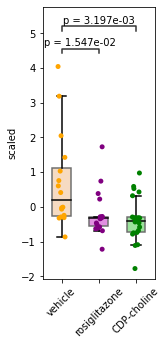

In [7]:
# compute the meta-p-values / batch p-values correctly
# make below into functionsb
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out/quant.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant.csv']

split = ['_','-','_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'plin2', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

In [6]:
# compute the meta-p-values / batch p-values correctly
# make below into functionsb
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out/quant.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant.csv']

split = ['_','-','_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'lipidspot', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

KeyError: 'Column not found: lipidspot'

vehicle vs. rosiglitazone: t-test independent samples, P_val:1.113e-03 t=3.479e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:1.394e-03 t=3.385e+00


Text(0.5, 24.0, '')

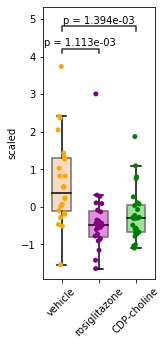

In [9]:
paths = ['../new_outs/iNbatch01172024_CTP1b_Lipidspot_out/quant_continuous.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant_continuous.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant_continuous.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant_continuous.csv']
split = ['_','-','_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'lipidspot', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

In [172]:
import sys
path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant/'
sys.path.append(path_to_quant)
from confocalQuant.data_handling import return_results, load_im_from_memmap
from confocalQuant.segmentation import get_czi_files, int_to_float, load_3D, extract_channels, impose_segmentation
from confocalQuant.image import compute_avs, get_rep_im, gamma_correct_image, bgrnd_subtract

out_parent = '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/'
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job = return_results(out_parent+'out.sbatch', '.')

In [25]:
df = pd.read_csv('../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant.csv')
df = df.groupby(['line', 'treatment', 'file'])['lipidspot'].mean().reset_index(name='lipidspot')
df.head()

line treatment       file  lipidspot
0   E3   vehicle  B06-1.czi   0.006106
1   E3   vehicle  B06-2.czi   0.001865
2   E3   vehicle  D07-1.czi   0.001848
3   E3   vehicle  E06-1.czi   0.001637
4   E3   vehicle  E06-2.czi   0.008029

In [34]:
files = get_czi_files('../new_data/iNbatch01312024_PLIN2_Lipidspot/')
mean_per_filename, mean_per_condition  = compute_avs(df, 'file', 'treatment', 'line', 'lipidspot')

In [29]:
treatments = np.unique(df['treatment'])
dict_treat = dict(zip(df['file'], df['treatment']))
dict_line = dict(zip(df['file'], df['line']))

In [112]:
c = get_rep_im('CDP-choline', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
r = get_rep_im('rosiglitazone', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
v = get_rep_im('vehicle', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)

In [344]:
rep = [v, r, c]

In [345]:
# determine upper dict
ma_out = []
mas_out = []

for i in rep:
    mask_sele, mat_sele = load_im_from_memmap(i, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    ma_out.append(mat_sele)
    mas_out.append(mask_sele)

In [367]:
mat_sele = np.vstack(ma_out)
mask_sele = np.vstack(mas_out)
mat_sele = extract_channels([0,1,2], mat_sele)

nums = [90, 95, 99.5]
upper_dict = dict(zip(range(3), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(3)]))
lower_dict = {0: 0, 1: 0, 2: 0}
gamma_dict = {0: 1, 1: 1, 2: 1}
background_dict = {0: 0, 1: 75, 2: 0}
percentile=False

In [364]:
parent = '../new_data/iNbatch01312024_PLIN2_Lipidspot/'

In [365]:
collabs = ['NeuN + DAPI',  'NeuN + DAPI + Mask', 'Mitohealth']
rowlabs = ['v', 'r', 'c']

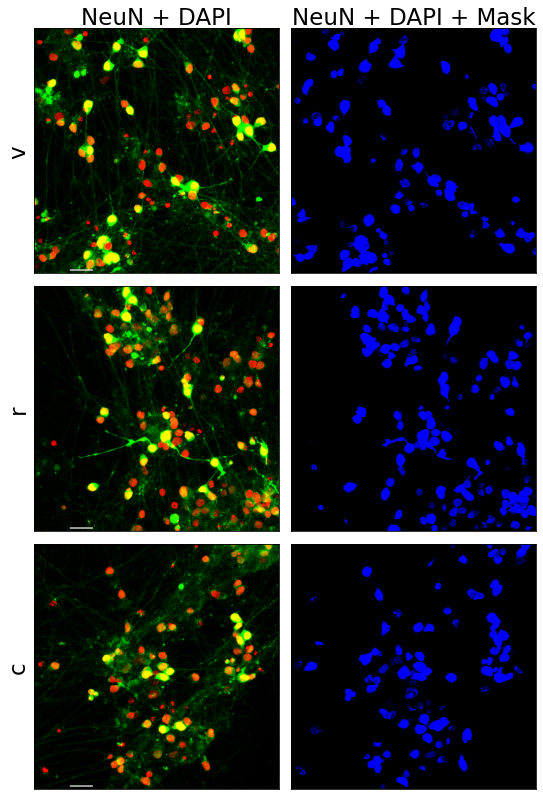

In [368]:
# show images
conditions = rep
fig, axes = plt.subplots(3, 2, figsize=(9, 14))
fig.subplots_adjust(hspace=0.05, wspace=0.05) 

for i in range(len(rep)):
    ID = conditions[i]
    mask_sele, mat_sele  = load_im_from_memmap(ID, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
    mat_sele = extract_channels([0,1,2], mat_sele)

    # make plots
    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[0,1], order=[0,1,2], mask_channel = [0], maskit=True, percentile=percentile)
    #d = impose_segmentation(mask_sele, mat_sele, val=1)
    #plt2 = get_mean_projections(d, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[0,1], order=[2,1,0], mask_channel = [0], maskit=True, percentile=percentile)
    plt3 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[1], order=[0,2,1], mask_channel = [1], maskit=True, percentile=percentile, mean=False)

    # get image
    imgA = AICSImage(parent + files[ID])

    plot_axis(axes, plt3, i,1, 0, imgA, collabs, rowlabs)
 
    #
    plot_axis(axes, plt1, i,0, 30, imgA, collabs, rowlabs)
    


#fig.savefig('./outs/all_outs/plots/1108_mito_resE_vehicle_rep_inset.png')


In [359]:
def get_mean_projections(mat, mask, background_dict, gamma_dict, lower_dict, upper_dict, channels, order, mask_channel, maskit=True, percentile=True, mean=True):
    """
    Generate mean or max projections from a 4D matrix, considering background subtraction, gamma correction, and channel extraction.

    Parameters:
    - mat: The 4D matrix containing image data.
    - mask: The binary mask for masking image data.
    - background_dict: A dictionary of background values for each channel.
    - gamma_dict: A dictionary of gamma values for each channel.
    - lower_dict: A dictionary of lower thresholds for each channel.
    - upper_dict: A dictionary of upper thresholds for each channel.
    - channels: The list of channel indices to extract.
    - order: The order of channels in the output.
    - mask_channel: The channels to consider when applying the mask.
    - maskit (bool): Flag to apply the mask.
    - percentile (bool): Flag to use percentile thresholds.
    - mean (bool): Flag to compute mean or max projections.

    Returns:
    - show_ordered: The resulting mean or max projection with adjusted properties.
    """
    mat_sub = bgrnd_subtract(mat, np.array(list(background_dict.values())))
    if maskit:
        mat_sub_masked = mat_sub.copy()
        for x in mask_channel:
            mat_sub_masked[mask==0,x]=0
        if mean:
            mat_proj = np.mean(mat_sub_masked, axis = (0))
        else:
            mat_proj = np.max(mat_sub_masked, axis = (0))

    else:
        if mean:
            mat_proj = np.mean(mat_sub, axis = (0))
        else:
            mat_proj = np.max(mat_sub, axis = (0))

    mat_g = gamma_correct_image(mat_proj, gamma_dict, lower_dict, upper_dict, is_4D=False, percentile=percentile)
    show = extract_channels(channels, mat_g, is_4D=False)
    show_ordered = show.copy()
    for i in range(show_ordered.shape[-1]):
        show_ordered[:,:,i] = show[:,:,order[i]]
    return show_ordered


In [336]:
np.argmax(mean_per_filename)

41

In [369]:
m, f = load_im_from_memmap(v, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)

In [569]:
T = extract_channels([1],f)


gamma_dict={0: 1, 1: .7, 2: 1}
lower_dict={0: 0, 1: 0, 2: 0}
upper_dict={0: 0, 1: 99.5, 2: 100}

mat_g = gamma_correct_image(T, gamma_dict, lower_dict, upper_dict, is_4D=True)
mat_g = impose_segmentation(m, mat_g,2)

//home/gridsan/djuna/homer/github/confocalQuant/confocalQuant/segmentation.py:199: RuntimeWarning: invalid value encountered in divide
  image_float = np.clip((image_float-lower)/(upper-lower), a_min = 0, a_max = 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


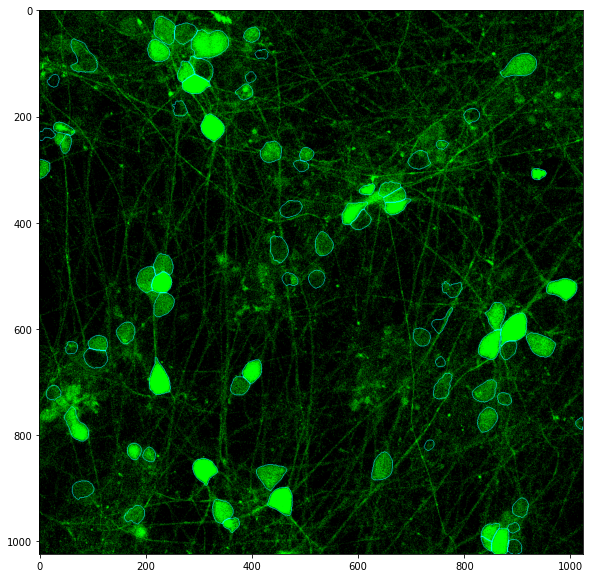

In [576]:
plt.figure(figsize=(10,10))
plt.imshow(mat_g[13])
                              

In [577]:
T = extract_channels([2],f)


gamma_dict={0: 1, 1: .7, 2: 1}
lower_dict={0: 0, 1: 0, 2: 0}
upper_dict={0: 0, 1: 99.5, 2: 99.5}

mat_g = gamma_correct_image(T, gamma_dict, lower_dict, upper_dict, is_4D=True)
mat_g = impose_segmentation(m, mat_g,2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


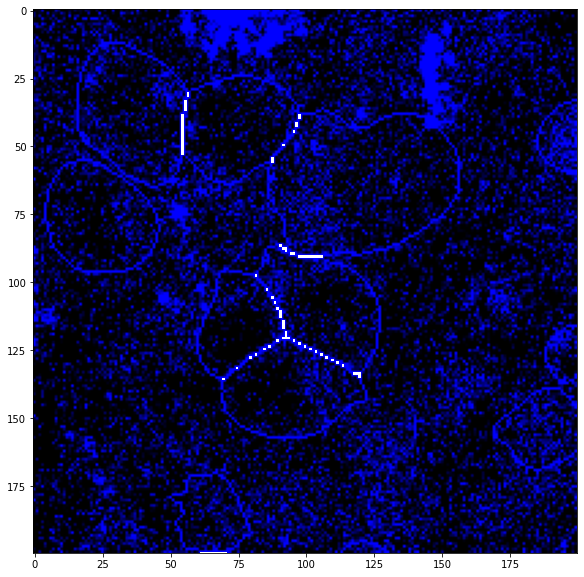

In [579]:
plt.figure(figsize=(10,10))
plt.imshow(mat_g[13][0:200,200:400])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


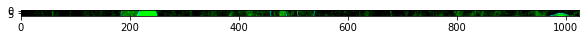

In [575]:
plt.figure(figsize=(10,10))
plt.imshow(mat_g[13][500:510])
                              

In [390]:


gamma_dict={0: 1, 1: .7, 2: 1}
lower_dict={0: 0, 1: 0, 2: 0}
upper_dict={0: 99.9, 1: 99, 2: 100}

mat_g = gamma_correct_image(T, gamma_dict, lower_dict, upper_dict, is_4D=True)
mat_g = impose_segmentation(m, mat_g,2)

In [397]:
T = extract_channels([2],f)


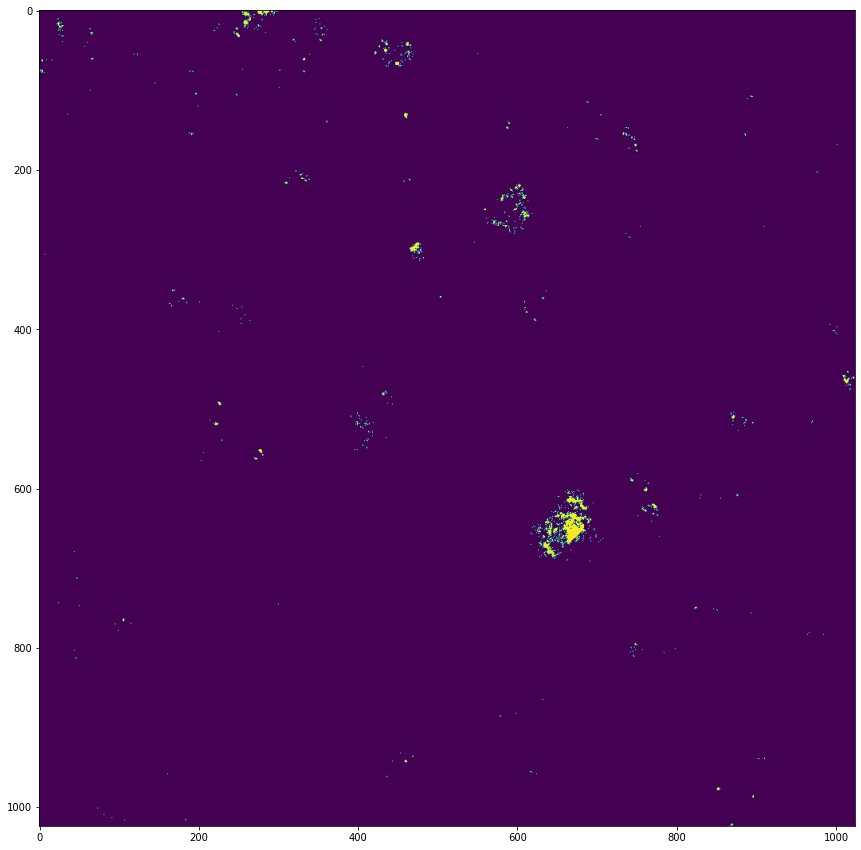

In [415]:
plt.figure(figsize=(15,15))
plt.imshow(np.max(f[:,:,:,3]>0.2627450980392157, axis=0))              

In [423]:
mat_g = impose_segmentation(m, (f[:,:,:,3]>0.2627450980392157),.5)

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

In [422]:
(f[:,:,:,3]>0.2627450980392157).shape

(28, 1024, 1024)

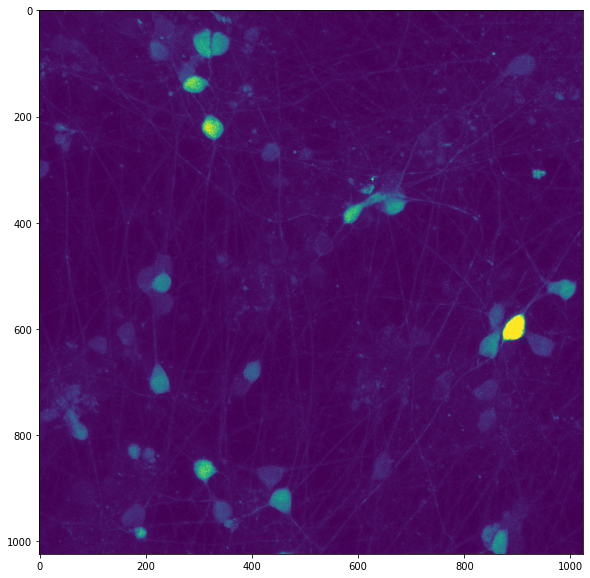

In [482]:
plt.figure(figsize=(10,10))

plt.imshow(np.max(f[:,:,:,1], axis=0))

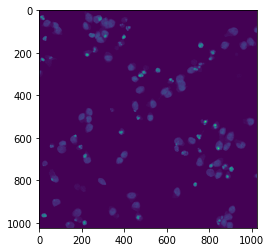

In [507]:
plt.imshow(T1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [566]:
m, f = load_im_from_memmap(v, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
T = np.mean(f[:,:,:,2]>.2, axis=0)
T[np.mean(m, axis=0)<1] = False

T0 = np.mean(f[:,:,:,3]>.2, axis=0)
T0[np.mean(m, axis=0)<1] = False

T1 = np.max(f[:,:,:,0], axis=0)
T1[np.mean(m, axis=0)<1] = 0

d = np.concatenate((np.expand_dims(T/0.1, axis=2), np.expand_dims(T0/0.1, axis=2), (np.expand_dims(T1/np.percentile(T1,99.5), axis=2))), axis=2)

In [509]:
d.shape

(1024, 1024, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


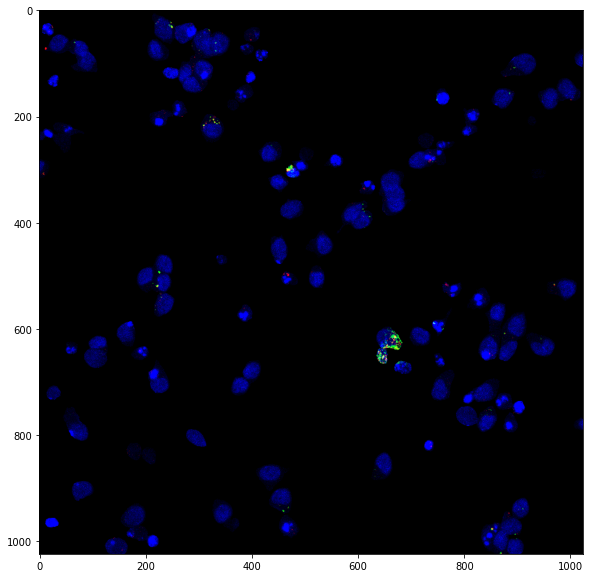

In [567]:
plt.figure(figsize=(10,10))
plt.imshow(d)#[700:1000,200:500])

In [559]:
m, f = load_im_from_memmap(c, zi_per_job, Nzi_per_job, probs, all_masks, all_mat)
T = np.mean(f[:,:,:,2], axis=0)
T[np.mean(m, axis=0)<1] = False

T0 = np.mean(f[:,:,:,3], axis=0)
T0[np.mean(m, axis=0)<1] = False

T1 = np.max(f[:,:,:,0], axis=0)
T1[np.mean(m, axis=0)<1] = 0

d = np.concatenate((np.expand_dims(T/0.1, axis=2), np.expand_dims(T0/0.1, axis=2), (np.expand_dims(T1/np.percentile(T1,99.9), axis=2))), axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


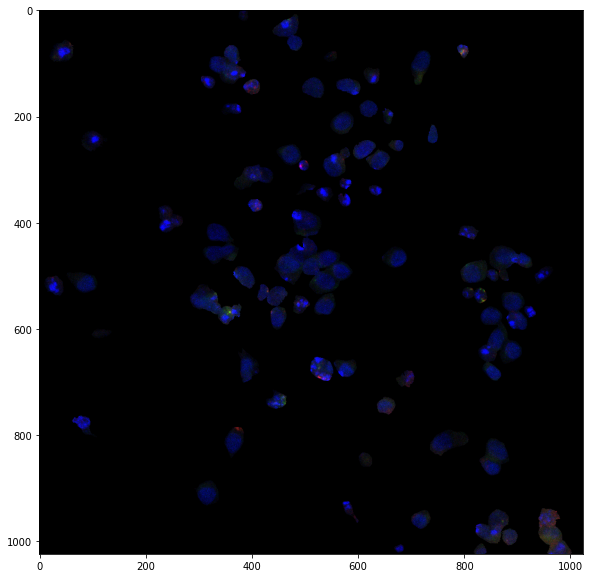

In [560]:
plt.figure(figsize=(10,10))
plt.imshow(d)#[700:1000,200:500])

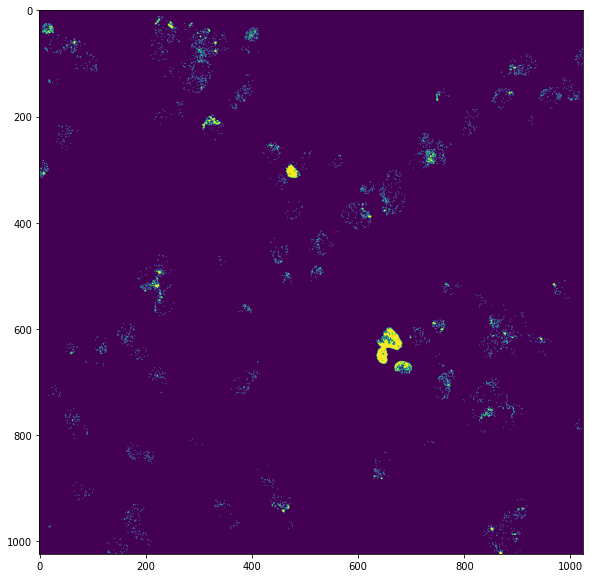

In [459]:
plt.figure(figsize=(10,10))
plt.imshow(T)

In [436]:
T0 = np.max(f[:,:,:,1], axis=0)

In [437]:

T.shape

(1024, 1024)

In [455]:
T0[:None].shape

(1024, 1024)

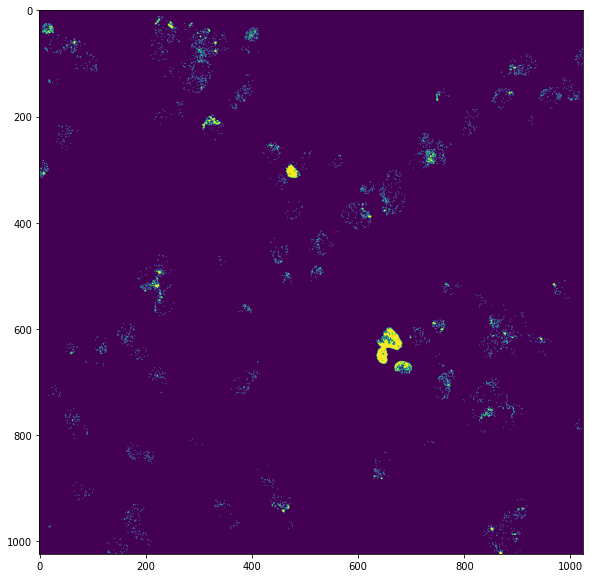

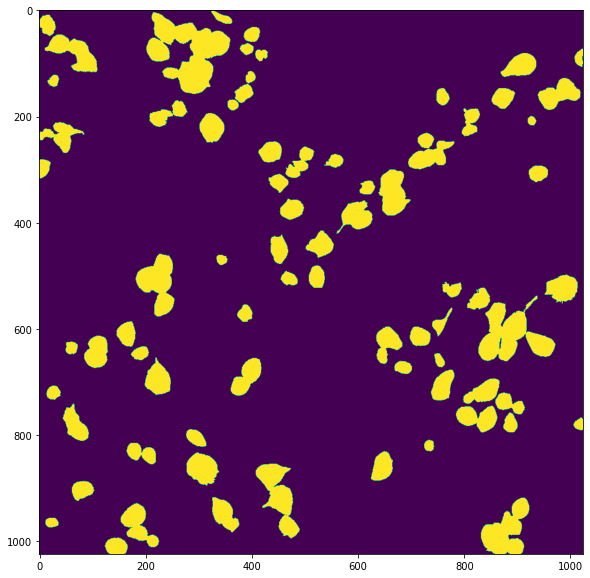

In [413]:
plt.figure(figsize=(10,10))
plt.imshow(np.mean(m, axis=0)>0)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

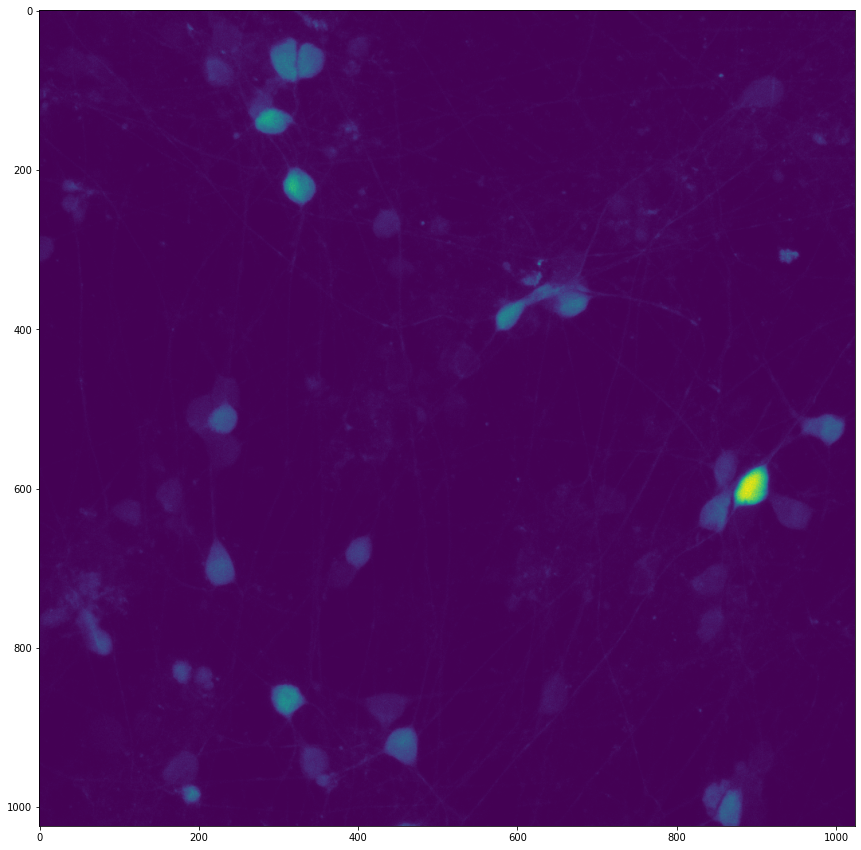

In [402]:
plt.figure(figsize=(15,15))
plt.imshow(np.mean(f[:,:,:,1], axis=0))              

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


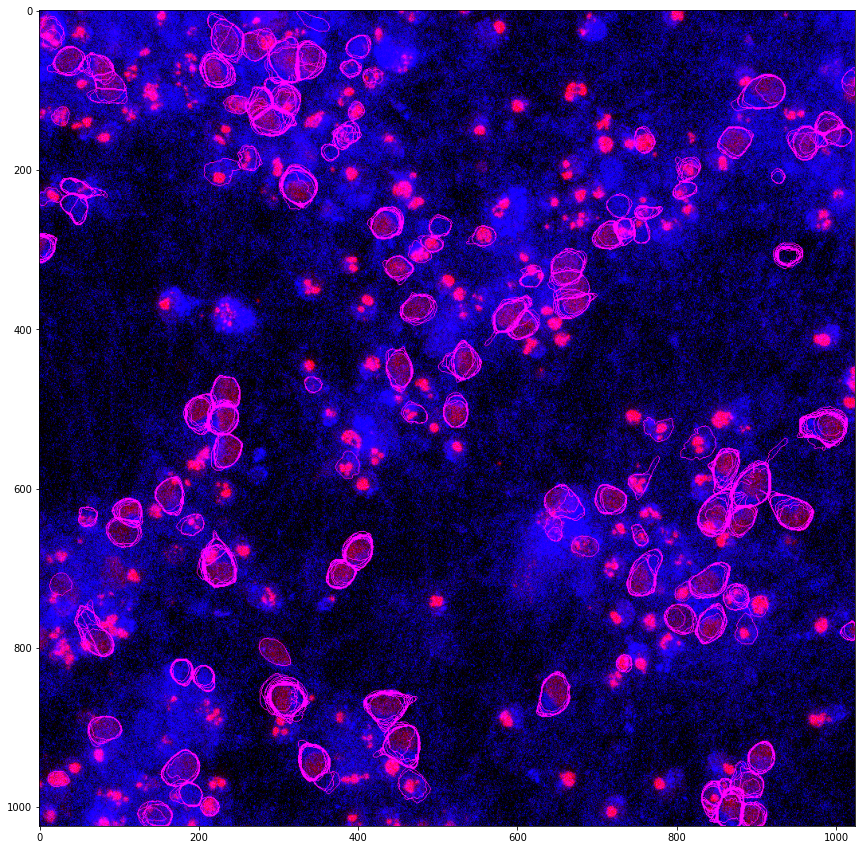

In [389]:
plt.figure(figsize=(15,15))
plt.imshow(np.max(mat_g,axis=0))
                              

In [342]:
T = extract_channels([2,3],f)


gamma_dict={0: 1, 1: 1, 2: 1}
lower_dict={0: 0, 1: 0, 2: 99.9}
upper_dict={0: 99.99, 1:99.99, 2: 99.99}

mat_g = gamma_correct_image(T, gamma_dict, lower_dict, upper_dict, is_4D=True)
mat_g = impose_segmentation(m, mat_g,.5)

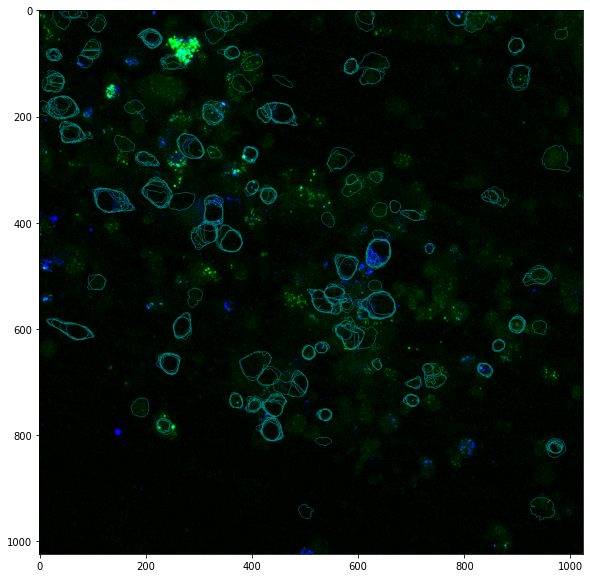

In [343]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(mat_g,axis=0))#[700:1000,200:500])
                              

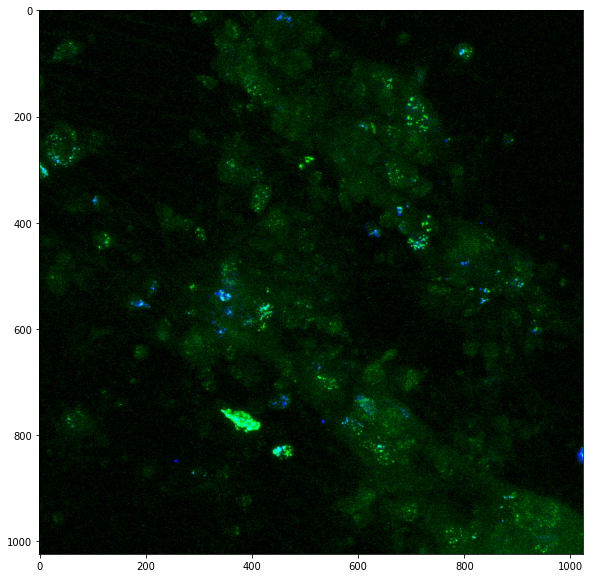

In [334]:
T = extract_channels([2,3],f)


gamma_dict={0: 1, 1: 1, 2: 1}
lower_dict={0: 0, 1: 0, 2: 99.9}
upper_dict={0: 99.99, 1:99.99, 2: 99.99}

mat_g = gamma_correct_image(T, gamma_dict, lower_dict, upper_dict, is_4D=True)
#mat_g = impose_segmentation(m, mat_g,.5)

plt.figure(figsize=(10,10))
plt.imshow(np.max(mat_g,axis=0))#[700:1000,200:500])
                              

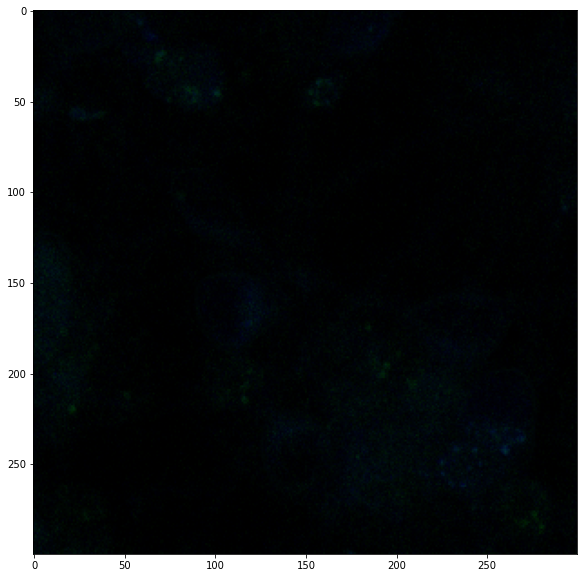

In [298]:
plt.figure(figsize=(10,10))
plt.imshow(np.mean(mat_g,axis=0)[700:1000,200:500])
                              

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


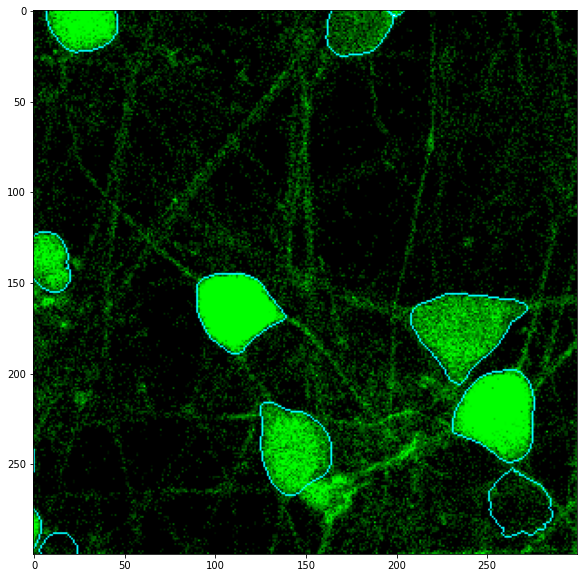

In [252]:
plt.figure(figsize=(10,10))
plt.imshow(mat_g[15][700:1000,200:500])
                              

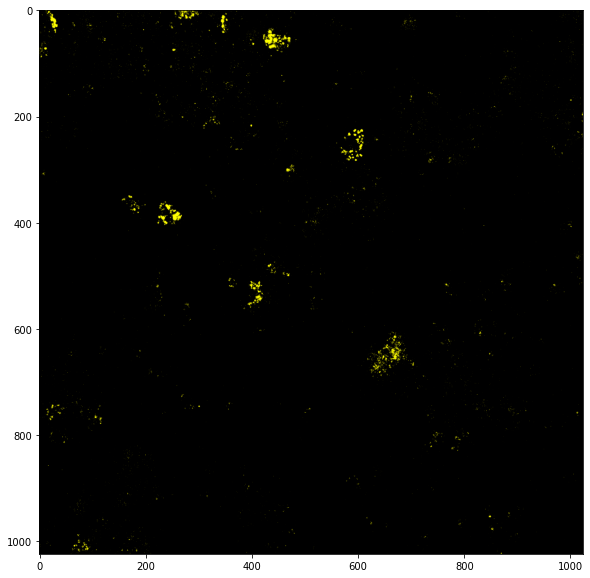

In [153]:
gamma_dict={0: 1, 1: 1, 2: 1, 3:1}
lower_dict={0: 0, 1: 0, 2: 0, 3:0}
upper_dict={0: 100, 1: 99.6, 2: 100}

mat_g = gamma_correct_image(T, gamma_dict, lower_dict, upper_dict, is_4D=True)

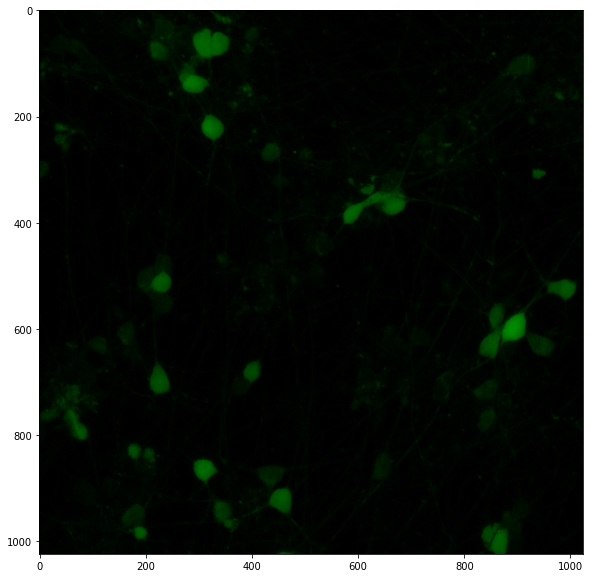

In [154]:
plt.figure(figsize=(10,10))
plt.imshow(np.mean(mat_g, axis=0))

In [176]:
def get_mean_projections(mat, mask, background_dict, gamma_dict, lower_dict, upper_dict, channels, order, mask_channel, maskit=True, percentile=True):
    mat_sub = bgrnd_subtract(mat, np.array(list(background_dict.values())))
    if maskit:
        mat_sub_masked = mat_sub.copy()
        for x in mask_channel:
            mat_sub_masked[mask==0,x]=0
        mat_proj = np.mean(mat_sub_masked, axis = (0))
    else:
        mat_proj = np.mean(mat_sub, axis = (0))

    mat_g = gamma_correct_image(mat_proj, gamma_dict, lower_dict, upper_dict, is_4D=False, percentile=percentile)
    show = extract_channels(channels, mat_g, is_4D=False)
    show_ordered = show.copy()
    for i in range(show_ordered.shape[-1]):
        show_ordered[:,:,i] = show[:,:,order[i]]
    return show_ordered

from matplotlib.patches import Rectangle

def add_inset(axes, j, i, plt, x1=200,x2=400,y1=400,y2=600):
    axin = axes[j,i].inset_axes([.4, .4, 0.6, 0.6])
    axin.set_xlim(x1, x2)
    axin.set_ylim(y1, y2)
    axin.imshow(plt)
    axes[j,i].indicate_inset_zoom(axin)
    axin.set_xticks([])
    axin.set_yticks([])
    border = Rectangle((0, 0), 5, 5, color='white', linewidth=5, fill=False, transform=axin.transAxes)
    axin.add_patch(border)
    
def add_scale_bar(size, img, plt):
    end = np.round(size/img.physical_pixel_sizes[2])
    for i in range(3):
        #plt[10:(10+int(end)),190:195,i] = 1
        plt[10:15,150:(150+int(end)),i] = 1
        
def plot_axis(axes, plt, j, i, size, img, collabs, rowlabs):
    add_scale_bar(size, img, plt)
    axes[j,i].imshow(plt, origin = 'lower')
    axes[j,i].set_xticks([])
    axes[j,i].set_yticks([])
    if j==0:
        axes[j,i].xaxis.set_label_position('top')
        axes[j,i].set_xlabel(collabs[i], fontsize=23)
    if i==0:
        axes[j,i].set_ylabel(rowlabs[j], fontsize=23)

In [155]:
T = extract_channels([1,2],f)

In [156]:
gamma_dict={0: 1, 1: 1, 2: 1, 3:1}
lower_dict={0: 0, 1: 0, 2: 99.9, 3:0}
upper_dict={0: 100, 1: 99.9, 2: 99.99}

mat_g = gamma_correct_image(T, gamma_dict, lower_dict, upper_dict, is_4D=True)

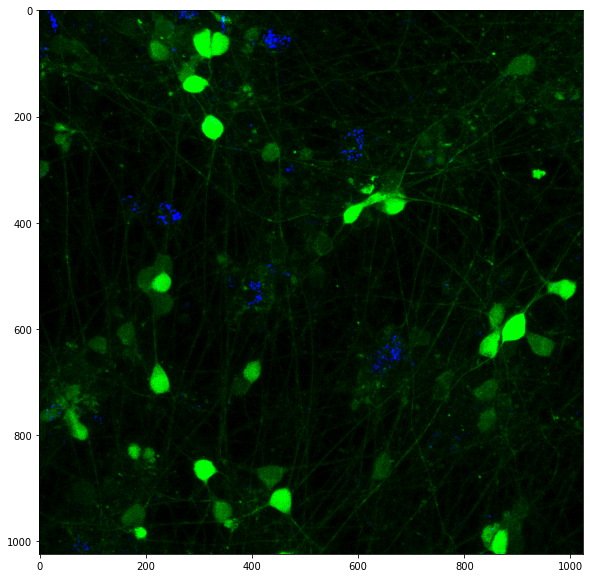

In [162]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(mat_g, axis=0))

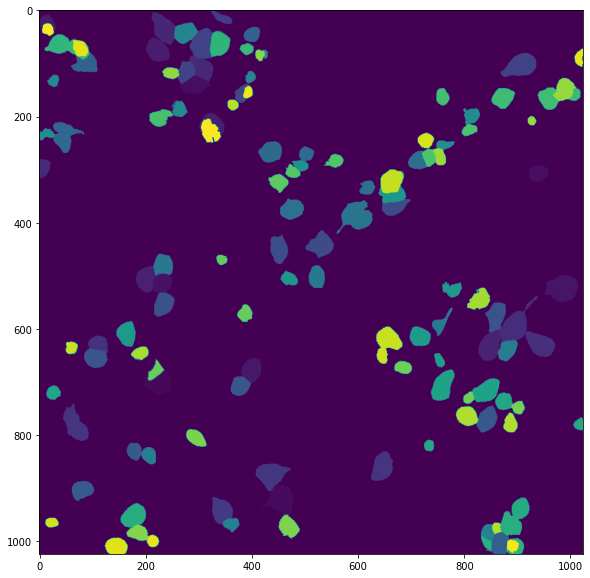

In [160]:
plt.figure(figsize=(10,10))

plt.imshow(np.max(m, axis=0))

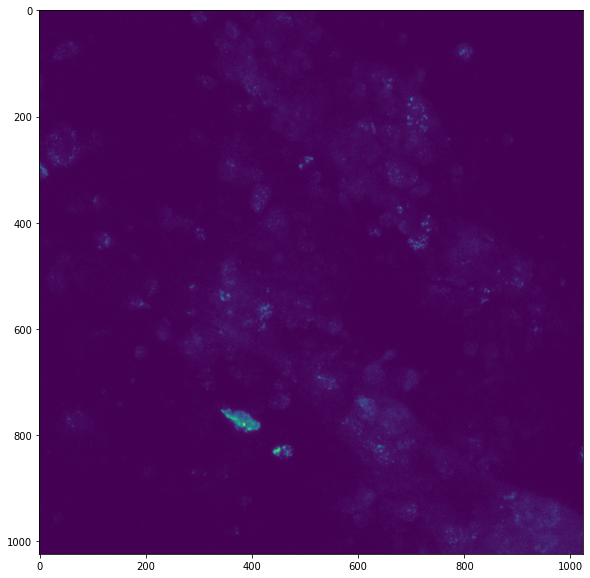

In [105]:
plt.figure(figsize=(10,10))
plt.imshow(np.mean(f[:,:,:,2], axis=0))

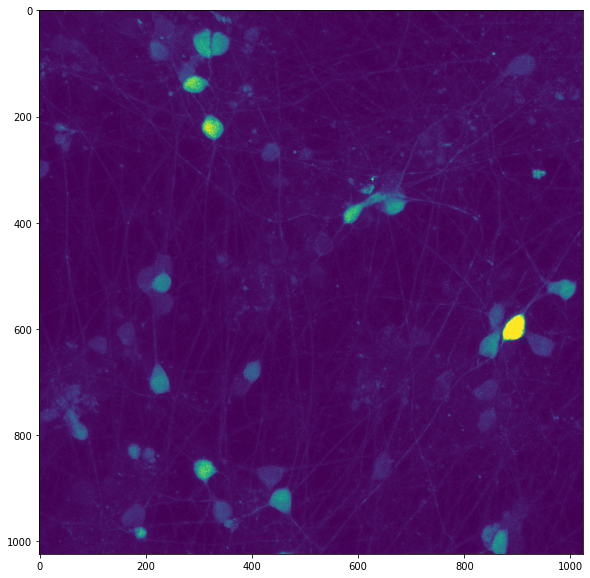

In [90]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(f[:,:,:,1], axis=0))

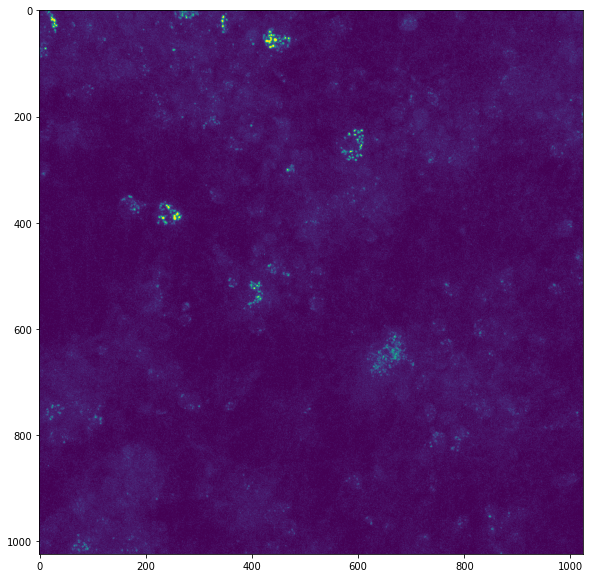

In [85]:
plt.figure(figsize=(10,10))

plt.imshow(np.max(x[:,:,:,2], axis=0))

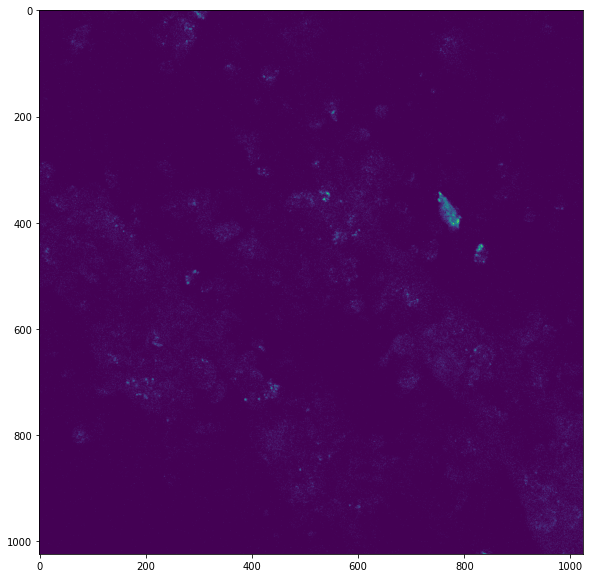

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(int_to_float(img.data[0][0][10]))

In [55]:
img.data[0].shape

(4, 27, 1024, 1024)

vehicle vs. rosiglitazone: t-test independent samples, P_val:1.938e-03 t=3.297e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:2.890e-04 t=3.910e+00


Text(0.5, 24.0, '')

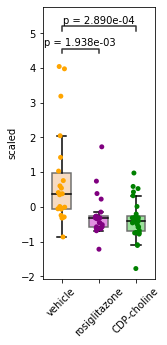

In [195]:
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out/quant.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant.csv']
split = ['_','-','_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'plin2', 'Y622', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

vehicle vs. rosiglitazone: t-test independent samples, P_val:3.125e-01 t=1.022e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:3.757e-01 t=8.956e-01


Text(0.5, 24.0, '')

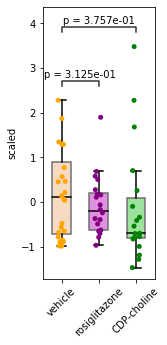

In [196]:
paths = ['../new_outs/iNbatch01172024_CTP1b_Lipidspot_out/quant.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant.csv']
split = ['_','-','_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'lipidspot', 'G2', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

vehicle vs. rosiglitazone: t-test independent samples, P_val:7.325e-01 t=-3.446e-01
vehicle vs. CDP-choline: t-test independent samples, P_val:6.716e-01 t=4.278e-01


Text(0.5, 24.0, '')

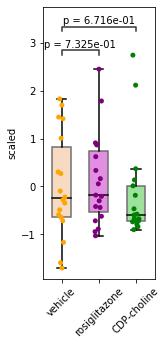

In [198]:
paths = ['../new_outs/iNbatch01172024_NeuN-PLIN2-NRF2_out/quant.csv',
         '../new_outs/iNbatch01312024_PLIN2_Lipidspot_out/quant.csv', 
         '../new_outs/iNbatch02212024_PLIN2_Lipidspot_out/quant.csv',
        '../new_outs/iNbatch02142024_PLIN2_Lipidspot_out/quant.csv']
split = ['_','-','_', '_']
batch_id = ['iNbatch01172024', 'iNbatch01312024', 'iNbatch02212024', 'iNbatch02142024']

out = [get_batch_values(paths[x], 'plin2', 'G2', split[x], batch_id[x]) for x in range(len(paths))]
temp = pd.concat(out)

colors = dict(zip(np.unique(temp['treatment']), [ 'lightgreen' , 'violet','peachpuff']))
colors2 = dict(zip(np.unique(temp['treatment']), [ 'green' , 'purple','orange']))

temp['treatment'] = pd.Categorical(temp['treatment'], categories=['vehicle', 'rosiglitazone', 'CDP-choline'], ordered=True)

temp.index = range(temp.shape[0])

plt.figure(figsize=(2,5))
ax = sns.boxplot(data = temp, x = 'treatment', showfliers=False, y = 'scaled', dodge = True, palette = colors, width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
sns.stripplot(data=temp, x='treatment', y='scaled',  dodge=True, jitter=True, alpha=1,  palette = colors2)

pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
annotator = Annotator(ax, pairs, data=temp, x='treatment', y='scaled')
annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
annotator.apply_and_annotate()
plt.xticks(rotation=45)
plt.xlabel('')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


vehicle vs. rosiglitazone: t-test independent samples, P_val:1.113e-03 t=3.479e+00
vehicle vs. CDP-choline: t-test independent samples, P_val:1.394e-03 t=3.385e+00


Text(0.5, 24.0, '')

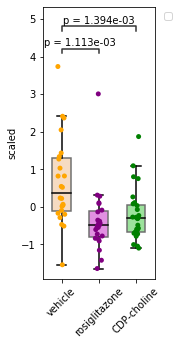

vehicle vs. CDP-choline: t-test independent samples, P_val:1.209e-02 t=2.639e+00
vehicle vs. rosiglitazone: t-test independent samples, P_val:1.000e-02 t=2.728e+00


Text(0.5, 24.0, '')

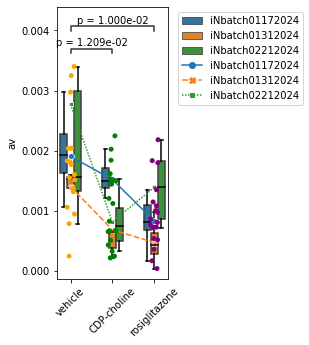

In [166]:
    plt.figure(figsize=(2,5))
    ax = sns.boxplot(data = temp, hue='batch', x = 'treatment', showfliers=False, y = 'av', dodge = True, order = ['vehicle', 'CDP-choline', 'rosiglitazone'], width=.5, boxprops=dict(alpha=1), medianprops=dict(color='black', alpha=1), whiskerprops=dict(color='black', alpha=1), capprops=dict(color = 'black', alpha=1))
    sns.stripplot(data=temp, x='treatment', y='av', palette = colors2, dodge=True, jitter=True, alpha=1,  order = ['vehicle', 'CDP-choline', 'rosiglitazone'])

    sns.lineplot(data=temp, x = 'treatment', hue='batch',y = 'av', style = 'batch', markers=True, dashes = True, err_style=None)

    
    pairs = [(("vehicle"), ("CDP-choline")), (("vehicle"), ("rosiglitazone"))]  # Define pairs to compare
    annotator = Annotator(ax, pairs, data=temp, x='treatment', y='av', order = ['vehicle', 'CDP-choline', 'rosiglitazone'])
    annotator.configure(test='t-test_ind', text_format='full', loc='inside', verbose=2, show_test_name=False)
    
    annotator.apply_and_annotate()
    
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.xlabel('')
    #plt.ylim(0,0.004)

In [96]:
means = temp.groupby(['treatment', 'batch']).mean().reset_index()


/state/partition1/slurm_tmp/25585438.0.0/ipykernel_382795/348746314.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = temp.groupby(['treatment', 'batch']).mean().reset_index()


In [111]:
temp.head()

line    treatment well        av    scaled            batch
26  Y622  CDP-choline  D02  0.001207 -0.281898  iNbatch01172024
27  Y622  CDP-choline  D03  0.002026  0.797609  iNbatch01172024
28  Y622  CDP-choline  D04  0.001479  0.076719  iNbatch01172024
29  Y622  CDP-choline  D05  0.002247  1.089849  iNbatch01172024
30  Y622  CDP-choline  E02  0.001619  0.261056  iNbatch01172024

In [114]:
temp.index = range(temp.shape[0])

<Axes: xlabel='treatment', ylabel='av'>

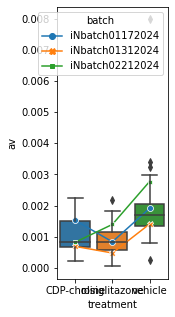

In [129]:
plt.figure(figsize=(2,5))
sns.lineplot(data=temp, x = 'treatment', hue='batch',y = 'av', style = 'batch', markers=True, dashes = False, err_style=None)
sns.boxplot(data=temp, x='treatment', y='av')#, order = ['vehicle', 'CDP-choline', 'rosiglitazone'])

AttributeError: Line2D.set() got an unexpected keyword argument 'order'

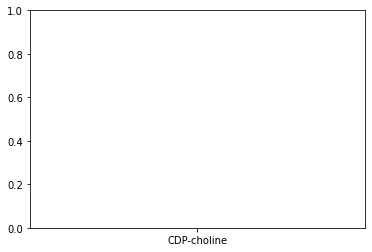

In [137]:
sns.lineplot(data=means, x = 'treatment', y = 'av', style = 'batch', markers=True, dashes = False, order = ['vehicle', 'CDP-choline', 'rosiglitazone'])

In [99]:
help(sns.lineplot)

Help on function lineplot in module seaborn.relational:

lineplot(*, x=None, y=None, hue=None, size=None, style=None, data=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, dashes=True, markers=None, style_order=None, units=None, estimator='mean', ci=95, n_boot=1000, seed=None, sort=True, err_style='band', err_kws=None, legend='auto', ax=None, **kwargs)
    Draw a line plot with possibility of several semantic groupings.
    
    The relationship between ``x`` and ``y`` can be shown for different subsets
    of the data using the ``hue``, ``size``, and ``style`` parameters. These
    parameters control what visual semantics are used to identify the different
    subsets. It is possible to show up to three dimensions independently by
    using all three semantic types, but this style of plot can be hard to
    interpret and is often ineffective. Using redundant semantics (i.e. both
    ``hue`` and ``style`` for the same variable) can be help

In [97]:
means

treatment            batch        av    scaled
0    CDP-choline  iNbatch01172024  0.001523  0.134126
1    CDP-choline  iNbatch01312024  0.000687 -0.246904
2    CDP-choline  iNbatch02212024  0.000821 -0.496713
3  rosiglitazone  iNbatch01172024  0.000833 -0.774945
4  rosiglitazone  iNbatch01312024  0.000475 -0.634666
5  rosiglitazone  iNbatch02212024  0.001392 -0.158907
6        vehicle  iNbatch01172024  0.001907  0.640818
7        vehicle  iNbatch01312024  0.001405  1.066748
8        vehicle  iNbatch02212024  0.002771  0.655620

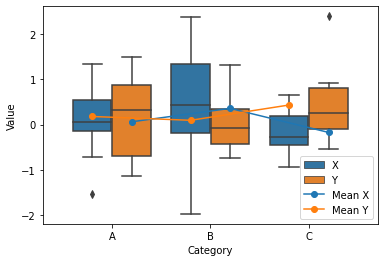

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample DataFrame
np.random.seed(10)
data = pd.DataFrame({
    'Category': np.repeat(['A', 'B', 'C'], 20),
    'Subcategory': np.tile(np.repeat(['X', 'Y'], 10), 3),
    'Value': np.random.randn(60)
})

# Create the boxplot
sns.boxplot(x='Category', y='Value', data=data, hue='Subcategory')

# Calculate means for each combination of Category and Subcategory
means = data.groupby(['Category', 'Subcategory']).mean().reset_index()

# Now, you want to connect means of Subcategories across Categories
# Find unique categories and subcategories
categories = data['Category'].unique()
subcategories = data['Subcategory'].unique()

# Prepare plot positions for each subcategory within each category boxplot
positions = np.arange(len(categories))
offset = 0.2  # Adjust based on the number of hues and your visual preference

# Plot lines connecting the same Subcategories across Categories
for subcat in subcategories:
    subcat_means = means[means['Subcategory'] == subcat]['Value']
    plt.plot(positions + offset, subcat_means, marker='o', linestyle='-', label=f'Mean {subcat}')
    offset *= -1  # This alternates the offset, adjust as needed for visibility

plt.legend()
plt.show()


In [55]:
temp

line      treatment well        av    scaled            batch
26  Y622    CDP-choline  D02  0.001207 -0.281898  iNbatch01172024
27  Y622    CDP-choline  D03  0.002026  0.797609  iNbatch01172024
28  Y622    CDP-choline  D04  0.001479  0.076719  iNbatch01172024
29  Y622    CDP-choline  D05  0.002247  1.089849  iNbatch01172024
30  Y622    CDP-choline  E02  0.001619  0.261056  iNbatch01172024
31  Y622    CDP-choline  E03  0.000656 -1.009304  iNbatch01172024
32  Y622    CDP-choline  E04  0.001444  0.029971  iNbatch01172024
33  Y622    CDP-choline  E05  0.001504  0.109007  iNbatch01172024
34  Y622  rosiglitazone  F02  0.001085 -0.443516  iNbatch01172024
35  Y622  rosiglitazone  F03  0.000867 -0.730611  iNbatch01172024
36  Y622  rosiglitazone  F04  0.001352 -0.090729  iNbatch01172024
37  Y622  rosiglitazone  F05  0.001149 -0.358175  iNbatch01172024
38  Y622  rosiglitazone  G02  0.000172 -1.647149  iNbatch01172024
39  Y622  rosiglitazone  G03  0.000731 -0.910262  iNbatch01172024
40  Y622  rosiglitazone  G04  0.000769 -0.859898  iNbatch01172024
41  Y622  rosiglitazone  G05  0.000542 -1.159217  iNbatch01172024
42  Y622        vehicle  B02  0.003248  2.409032  iNbatch01172024
43  Y622        vehicle  B03  0.002040  0.815844  iNbatch01172024
44  Y622        vehicle  B04  0.002972  2.045821  iNbatch01172024
45  Y622        vehicle  B05  0.001813  0.517394  iNbatch01172024
46  Y622        vehicle  C02  0.000248 -1.546373  iNbatch01172024
47  Y622        vehicle  C03  0.002042  0.818562  iNbatch01172024
48  Y622        vehicle  C04  0.001062 -0.473591  iNbatch01172024
49  Y622        vehicle  C05  0.001830  0.539859  iNbatch01172024
17  Y622    CDP-choline  D03  0.000671 -0.276681  iNbatch01312024
18  Y622    CDP-choline  D04  0.000248 -1.049874  iNbatch01312024
19  Y622    CDP-choline  D05  0.000661 -0.294294  iNbatch01312024
20  Y622    CDP-choline  E02  0.000219 -1.102390  iNbatch01312024
21  Y622    CDP-choline  E03  0.000655 -0.305047  iNbatch01312024
22  Y622    CDP-choline  E04  0.001843  1.867985  iNbatch01312024
23  Y622    CDP-choline  E05  0.000511 -0.568025  iNbatch01312024
24  Y622  rosiglitazone  F03  0.000521 -0.550137  iNbatch01312024
25  Y622  rosiglitazone  F05  0.000974  0.278877  iNbatch01312024
26  Y622  rosiglitazone  G04  0.000362 -0.841596  iNbatch01312024
27  Y622  rosiglitazone  G05  0.000042 -1.425810  iNbatch01312024
28  Y622        vehicle  B03  0.000949  0.232658  iNbatch01312024
29  Y622        vehicle  B05  0.001604  1.430788  iNbatch01312024
30  Y622        vehicle  C04  0.001551  1.334299  iNbatch01312024
31  Y622        vehicle  C05  0.001516  1.269245  iNbatch01312024
23  Y622    CDP-choline  D03  0.001534 -0.075444  iNbatch02212024
24  Y622    CDP-choline  D04  0.000330 -0.786586  iNbatch02212024
25  Y622    CDP-choline  D05  0.001124 -0.317517  iNbatch02212024
26  Y622    CDP-choline  E03  0.000434 -0.725576  iNbatch02212024
27  Y622    CDP-choline  E04  0.000674 -0.583443  iNbatch02212024
28  Y622    CDP-choline  E05  0.000829 -0.491713  iNbatch02212024
29  Y622  rosiglitazone  F03  0.001006 -0.387255  iNbatch02212024
30  Y622  rosiglitazone  F04  0.001836  0.103048  iNbatch02212024
31  Y622  rosiglitazone  F05  0.000720 -0.556450  iNbatch02212024
32  Y622  rosiglitazone  G03  0.001801  0.082385  iNbatch02212024
33  Y622  rosiglitazone  G04  0.000809 -0.503849  iNbatch02212024
34  Y622  rosiglitazone  G05  0.002184  0.308682  iNbatch02212024
35  Y622        vehicle  B03  0.007980  3.734007  iNbatch02212024
36  Y622        vehicle  B04  0.003400  1.027633  iNbatch02212024
37  Y622        vehicle  B05  0.000789 -0.515712  iNbatch02212024
38  Y622        vehicle  C03  0.001367 -0.173923  iNbatch02212024
39  Y622        vehicle  C04  0.001769  0.063829  iNbatch02212024
40  Y622        vehicle  C05  0.001319 -0.202116  iNbatch02212024

In [32]:
avg_lipidspot = avg_lipidspot[avg_lipidspot['line']=='Y622']

In [ ]:
avg_lipi

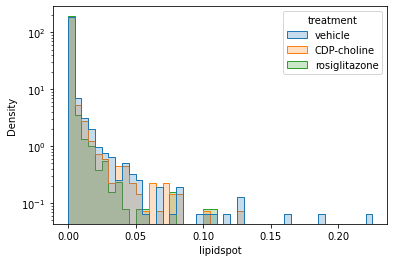

In [25]:
sns.histplot(data = df[df['line']=='Y622'], x = 'lipidspot', hue = 'treatment',element="step", stat = 'density', common_norm=False, binwidth=.005)
plt.yscale('log')

In [12]:
df

Unnamed: 0      dapi      neun  lipidspot     size  file_ID  mask_ID  \
0               0  0.005269  0.000121        0.0    332.0        0        1   
1               1  0.008535  0.000776        0.0    839.0        0        2   
2               2  0.000320  0.022401        0.0   2375.0        0        3   
3               3  0.000916  0.031413        0.0   1677.0        0        4   
4               4  0.041998  0.246575        0.0  20824.0        0        5   
...           ...       ...       ...        ...      ...      ...      ...   
15542         120  0.101562  0.040003        0.0    615.0      109      121   
15543         121  0.061008  0.018094        0.0   2223.0      109      122   
15544         122  0.025428  0.008273        0.0   3742.0      109      123   
15545         123  0.035661  0.004724        0.0    805.0      109      124   
15546         124  0.010797  0.003025        0.0    712.0      109      125   

            file  line      treatment  
0      B02_1.czi  Y622        vehicle  
1      B02_1.czi  Y622        vehicle  
2      B02_1.czi  Y622        vehicle  
3      B02_1.czi  Y622        vehicle  
4      B02_1.czi  Y622        vehicle  
...          ...   ...            ...  
15542  G11_2.czi    G2  rosiglitazone  
15543  G11_2.czi    G2  rosiglitazone  
15544  G11_2.czi    G2  rosiglitazone  
15545  G11_2.czi    G2  rosiglitazone  
15546  G11_2.czi    G2  rosiglitazone  

[15547 rows x 10 columns]

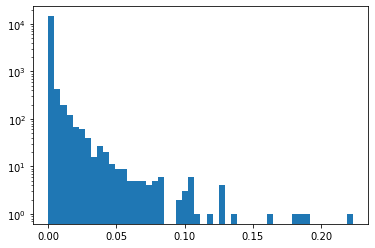

In [11]:
plt.hist(df['lipidspot'], 50, None)
plt.yscale('log')

In [ ]:
# def meta_p_values function

In [ ]:
# Do rep image plotting here